In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'native','im':'t1','fe':['b25'],'fi':['roi']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'basal_seg',
    'balance_data'  : True,
    'exclude'       : ['normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_0_0_0_1_normalized_e_n_e_0_0_e_0_0_basal_seg_data_norm_b25_roi_t1_native_k5_b25_t1_0_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(1078212, 304)
(1078212, 3)
validation
(151755, 304)
(151755, 3)
test
(135990, 304)
(135990, 3)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 304)]             0         


 dense (Dense)               (None, 1024)              312320    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 3)                 387       


Total params: 1001731 (3.82 MB)


Trainable params: 1001731 (3.82 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/108 [..............................] - ETA: 2:36 - loss: 1.2644 - STD: 0.1705 - MAE: 0.4421

  5/108 [>.............................] - ETA: 1s - loss: 1.1691 - STD: 0.1056 - MAE: 0.4440  

  9/108 [=>............................] - ETA: 1s - loss: 1.1449 - STD: 0.0847 - MAE: 0.4442

 13/108 [==>...........................] - ETA: 1s - loss: 1.1362 - STD: 0.0773 - MAE: 0.4442

 17/108 [===>..........................] - ETA: 1s - loss: 1.1289 - STD: 0.0680 - MAE: 0.4442

 21/108 [====>.........................] - ETA: 1s - loss: 1.1242 - STD: 0.0615 - MAE: 0.4442

 25/108 [=====>........................] - ETA: 1s - loss: 1.1202 - STD: 0.0561 - MAE: 0.4441

 29/108 [=======>......................] - ETA: 1s - loss: 1.1174 - STD: 0.0518 - MAE: 0.4441

 33/108 [========>.....................] - ETA: 1s - loss: 1.1149 - STD: 0.0478 - MAE: 0.4441

 37/108 [=========>....................] - ETA: 1s - loss: 1.1128 - STD: 0.0442 - MAE: 0.4440

 41/108 [==========>...................] - ETA: 0s - loss: 1.1109 - STD: 0.0416 - MAE: 0.4439

 45/108 [===========>..................] - ETA: 0s - loss: 1.1091 - STD: 0.0389 - MAE: 0.4438

 49/108 [============>.................] - ETA: 0s - loss: 1.1072 - STD: 0.0369 - MAE: 0.4436

 53/108 [=============>................] - ETA: 0s - loss: 1.1050 - STD: 0.0353 - MAE: 0.4433

 57/108 [==============>...............] - ETA: 0s - loss: 1.1024 - STD: 0.0347 - MAE: 0.4428

 61/108 [===============>..............] - ETA: 0s - loss: 1.0988 - STD: 0.0352 - MAE: 0.4420

 65/108 [=================>............] - ETA: 0s - loss: 1.0940 - STD: 0.0375 - MAE: 0.4407

 69/108 [==================>...........] - ETA: 0s - loss: 1.0880 - STD: 0.0416 - MAE: 0.4388

 73/108 [===================>..........] - ETA: 0s - loss: 1.0810 - STD: 0.0473 - MAE: 0.4362

 77/108 [====================>.........] - ETA: 0s - loss: 1.0733 - STD: 0.0533 - MAE: 0.4333

 81/108 [=====================>........] - ETA: 0s - loss: 1.0654 - STD: 0.0590 - MAE: 0.4304

 85/108 [======================>.......] - ETA: 0s - loss: 1.0574 - STD: 0.0645 - MAE: 0.4275

 87/108 [=======================>......] - ETA: 0s - loss: 1.0536 - STD: 0.0674 - MAE: 0.4259

 91/108 [========================>.....] - ETA: 0s - loss: 1.0455 - STD: 0.0732 - MAE: 0.4227

 95/108 [=========================>....] - ETA: 0s - loss: 1.0376 - STD: 0.0792 - MAE: 0.4194

 99/108 [==========================>...] - ETA: 0s - loss: 1.0300 - STD: 0.0846 - MAE: 0.4164

103/108 [===========================>..] - ETA: 0s - loss: 1.0230 - STD: 0.0899 - MAE: 0.4134

107/108 [============================>.] - ETA: 0s - loss: 1.0160 - STD: 0.0951 - MAE: 0.4105

108/108 [==============================] - 5s 30ms/step - loss: 1.0142 - STD: 0.0963 - MAE: 0.4098 - val_loss: 0.7946 - val_STD: 0.2310 - val_MAE: 0.3222


Epoch 2/10000


  1/108 [..............................] - ETA: 3s - loss: 0.8362 - STD: 0.2364 - MAE: 0.3311

  5/108 [>.............................] - ETA: 1s - loss: 0.8336 - STD: 0.2335 - MAE: 0.3317

  9/108 [=>............................] - ETA: 1s - loss: 0.8297 - STD: 0.2330 - MAE: 0.3311

 13/108 [==>...........................] - ETA: 1s - loss: 0.8255 - STD: 0.2352 - MAE: 0.3292

 17/108 [===>..........................] - ETA: 1s - loss: 0.8238 - STD: 0.2371 - MAE: 0.3279

 21/108 [====>.........................] - ETA: 1s - loss: 0.8212 - STD: 0.2381 - MAE: 0.3269

 25/108 [=====>........................] - ETA: 1s - loss: 0.8200 - STD: 0.2389 - MAE: 0.3262

 29/108 [=======>......................] - ETA: 1s - loss: 0.8184 - STD: 0.2402 - MAE: 0.3253

 33/108 [========>.....................] - ETA: 1s - loss: 0.8163 - STD: 0.2416 - MAE: 0.3241

 37/108 [=========>....................] - ETA: 0s - loss: 0.8151 - STD: 0.2422 - MAE: 0.3236

 41/108 [==========>...................] - ETA: 0s - loss: 0.8136 - STD: 0.2430 - MAE: 0.3229

 45/108 [===========>..................] - ETA: 0s - loss: 0.8123 - STD: 0.2442 - MAE: 0.3220

 49/108 [============>.................] - ETA: 0s - loss: 0.8112 - STD: 0.2450 - MAE: 0.3213

 53/108 [=============>................] - ETA: 0s - loss: 0.8101 - STD: 0.2457 - MAE: 0.3208

 57/108 [==============>...............] - ETA: 0s - loss: 0.8087 - STD: 0.2465 - MAE: 0.3201

 61/108 [===============>..............] - ETA: 0s - loss: 0.8077 - STD: 0.2472 - MAE: 0.3196

 65/108 [=================>............] - ETA: 0s - loss: 0.8065 - STD: 0.2477 - MAE: 0.3191

 69/108 [==================>...........] - ETA: 0s - loss: 0.8053 - STD: 0.2484 - MAE: 0.3185

 73/108 [===================>..........] - ETA: 0s - loss: 0.8042 - STD: 0.2490 - MAE: 0.3179

 77/108 [====================>.........] - ETA: 0s - loss: 0.8034 - STD: 0.2494 - MAE: 0.3175

 81/108 [=====================>........] - ETA: 0s - loss: 0.8024 - STD: 0.2500 - MAE: 0.3170

 85/108 [======================>.......] - ETA: 0s - loss: 0.8018 - STD: 0.2505 - MAE: 0.3166

 89/108 [=======================>......] - ETA: 0s - loss: 0.8009 - STD: 0.2509 - MAE: 0.3163

 93/108 [========================>.....] - ETA: 0s - loss: 0.7999 - STD: 0.2513 - MAE: 0.3159

 97/108 [=========================>....] - ETA: 0s - loss: 0.7988 - STD: 0.2518 - MAE: 0.3154

101/108 [===========================>..] - ETA: 0s - loss: 0.7981 - STD: 0.2523 - MAE: 0.3150

105/108 [============================>.] - ETA: 0s - loss: 0.7974 - STD: 0.2526 - MAE: 0.3147

108/108 [==============================] - 2s 15ms/step - loss: 0.7967 - STD: 0.2529 - MAE: 0.3144 - val_loss: 0.8233 - val_STD: 0.2625 - val_MAE: 0.3147


Epoch 3/10000


  1/108 [..............................] - ETA: 3s - loss: 0.7726 - STD: 0.2585 - MAE: 0.3069

  5/108 [>.............................] - ETA: 1s - loss: 0.7706 - STD: 0.2657 - MAE: 0.3026

  9/108 [=>............................] - ETA: 1s - loss: 0.7683 - STD: 0.2655 - MAE: 0.3021

 13/108 [==>...........................] - ETA: 1s - loss: 0.7669 - STD: 0.2648 - MAE: 0.3022

 17/108 [===>..........................] - ETA: 1s - loss: 0.7674 - STD: 0.2651 - MAE: 0.3022

 21/108 [====>.........................] - ETA: 1s - loss: 0.7673 - STD: 0.2654 - MAE: 0.3020

 25/108 [=====>........................] - ETA: 1s - loss: 0.7674 - STD: 0.2660 - MAE: 0.3017

 29/108 [=======>......................] - ETA: 1s - loss: 0.7667 - STD: 0.2665 - MAE: 0.3013

 33/108 [========>.....................] - ETA: 1s - loss: 0.7663 - STD: 0.2666 - MAE: 0.3011

 37/108 [=========>....................] - ETA: 1s - loss: 0.7654 - STD: 0.2666 - MAE: 0.3010

 41/108 [==========>...................] - ETA: 0s - loss: 0.7647 - STD: 0.2670 - MAE: 0.3006

 45/108 [===========>..................] - ETA: 0s - loss: 0.7639 - STD: 0.2676 - MAE: 0.3001

 49/108 [============>.................] - ETA: 0s - loss: 0.7637 - STD: 0.2679 - MAE: 0.2999

 53/108 [=============>................] - ETA: 0s - loss: 0.7635 - STD: 0.2681 - MAE: 0.2998

 57/108 [==============>...............] - ETA: 0s - loss: 0.7628 - STD: 0.2681 - MAE: 0.2997

 61/108 [===============>..............] - ETA: 0s - loss: 0.7623 - STD: 0.2685 - MAE: 0.2994

 65/108 [=================>............] - ETA: 0s - loss: 0.7623 - STD: 0.2687 - MAE: 0.2993

 69/108 [==================>...........] - ETA: 0s - loss: 0.7621 - STD: 0.2687 - MAE: 0.2992

 73/108 [===================>..........] - ETA: 0s - loss: 0.7611 - STD: 0.2689 - MAE: 0.2989

 77/108 [====================>.........] - ETA: 0s - loss: 0.7604 - STD: 0.2691 - MAE: 0.2986

 81/108 [=====================>........] - ETA: 0s - loss: 0.7600 - STD: 0.2694 - MAE: 0.2984

 85/108 [======================>.......] - ETA: 0s - loss: 0.7596 - STD: 0.2695 - MAE: 0.2983

 89/108 [=======================>......] - ETA: 0s - loss: 0.7592 - STD: 0.2699 - MAE: 0.2980

 93/108 [========================>.....] - ETA: 0s - loss: 0.7587 - STD: 0.2702 - MAE: 0.2978

 97/108 [=========================>....] - ETA: 0s - loss: 0.7583 - STD: 0.2703 - MAE: 0.2976

101/108 [===========================>..] - ETA: 0s - loss: 0.7581 - STD: 0.2704 - MAE: 0.2975

105/108 [============================>.] - ETA: 0s - loss: 0.7576 - STD: 0.2705 - MAE: 0.2974

108/108 [==============================] - 2s 16ms/step - loss: 0.7571 - STD: 0.2706 - MAE: 0.2972 - val_loss: 0.7613 - val_STD: 0.2808 - val_MAE: 0.2907


Epoch 4/10000


  1/108 [..............................] - ETA: 3s - loss: 0.7442 - STD: 0.2762 - MAE: 0.2918

  5/108 [>.............................] - ETA: 1s - loss: 0.7455 - STD: 0.2748 - MAE: 0.2928

  9/108 [=>............................] - ETA: 1s - loss: 0.7428 - STD: 0.2755 - MAE: 0.2918

 13/108 [==>...........................] - ETA: 1s - loss: 0.7406 - STD: 0.2760 - MAE: 0.2909

 17/108 [===>..........................] - ETA: 1s - loss: 0.7409 - STD: 0.2762 - MAE: 0.2908

 21/108 [====>.........................] - ETA: 1s - loss: 0.7401 - STD: 0.2768 - MAE: 0.2904

 25/108 [=====>........................] - ETA: 1s - loss: 0.7401 - STD: 0.2768 - MAE: 0.2903

 29/108 [=======>......................] - ETA: 1s - loss: 0.7396 - STD: 0.2768 - MAE: 0.2902

 33/108 [========>.....................] - ETA: 1s - loss: 0.7389 - STD: 0.2770 - MAE: 0.2900

 37/108 [=========>....................] - ETA: 1s - loss: 0.7388 - STD: 0.2772 - MAE: 0.2898

 41/108 [==========>...................] - ETA: 0s - loss: 0.7381 - STD: 0.2774 - MAE: 0.2896

 45/108 [===========>..................] - ETA: 0s - loss: 0.7378 - STD: 0.2777 - MAE: 0.2893

 49/108 [============>.................] - ETA: 0s - loss: 0.7376 - STD: 0.2781 - MAE: 0.2890

 53/108 [=============>................] - ETA: 0s - loss: 0.7376 - STD: 0.2783 - MAE: 0.2889

 57/108 [==============>...............] - ETA: 0s - loss: 0.7373 - STD: 0.2784 - MAE: 0.2888

 61/108 [===============>..............] - ETA: 0s - loss: 0.7375 - STD: 0.2784 - MAE: 0.2889

 65/108 [=================>............] - ETA: 0s - loss: 0.7374 - STD: 0.2786 - MAE: 0.2887

 69/108 [==================>...........] - ETA: 0s - loss: 0.7371 - STD: 0.2786 - MAE: 0.2886

 73/108 [===================>..........] - ETA: 0s - loss: 0.7364 - STD: 0.2787 - MAE: 0.2884

 77/108 [====================>.........] - ETA: 0s - loss: 0.7360 - STD: 0.2788 - MAE: 0.2883

 81/108 [=====================>........] - ETA: 0s - loss: 0.7356 - STD: 0.2790 - MAE: 0.2881

 85/108 [======================>.......] - ETA: 0s - loss: 0.7353 - STD: 0.2792 - MAE: 0.2879

 89/108 [=======================>......] - ETA: 0s - loss: 0.7354 - STD: 0.2792 - MAE: 0.2879

 93/108 [========================>.....] - ETA: 0s - loss: 0.7354 - STD: 0.2794 - MAE: 0.2878

 97/108 [=========================>....] - ETA: 0s - loss: 0.7350 - STD: 0.2795 - MAE: 0.2877

101/108 [===========================>..] - ETA: 0s - loss: 0.7347 - STD: 0.2795 - MAE: 0.2876

105/108 [============================>.] - ETA: 0s - loss: 0.7346 - STD: 0.2797 - MAE: 0.2874

108/108 [==============================] - 2s 16ms/step - loss: 0.7344 - STD: 0.2798 - MAE: 0.2873 - val_loss: 0.7578 - val_STD: 0.2846 - val_MAE: 0.2881


Epoch 5/10000


  1/108 [..............................] - ETA: 3s - loss: 0.7287 - STD: 0.2804 - MAE: 0.2858

  5/108 [>.............................] - ETA: 1s - loss: 0.7298 - STD: 0.2813 - MAE: 0.2857

  9/108 [=>............................] - ETA: 1s - loss: 0.7305 - STD: 0.2837 - MAE: 0.2844

 13/108 [==>...........................] - ETA: 1s - loss: 0.7313 - STD: 0.2843 - MAE: 0.2842

 17/108 [===>..........................] - ETA: 1s - loss: 0.7306 - STD: 0.2834 - MAE: 0.2846

 21/108 [====>.........................] - ETA: 1s - loss: 0.7306 - STD: 0.2834 - MAE: 0.2845

 25/108 [=====>........................] - ETA: 1s - loss: 0.7311 - STD: 0.2835 - MAE: 0.2845

 29/108 [=======>......................] - ETA: 1s - loss: 0.7317 - STD: 0.2832 - MAE: 0.2848

 33/108 [========>.....................] - ETA: 1s - loss: 0.7312 - STD: 0.2831 - MAE: 0.2847

 37/108 [=========>....................] - ETA: 0s - loss: 0.7307 - STD: 0.2830 - MAE: 0.2847

 41/108 [==========>...................] - ETA: 0s - loss: 0.7306 - STD: 0.2827 - MAE: 0.2848

 45/108 [===========>..................] - ETA: 0s - loss: 0.7297 - STD: 0.2828 - MAE: 0.2846

 49/108 [============>.................] - ETA: 0s - loss: 0.7290 - STD: 0.2829 - MAE: 0.2844

 53/108 [=============>................] - ETA: 0s - loss: 0.7284 - STD: 0.2830 - MAE: 0.2842

 57/108 [==============>...............] - ETA: 0s - loss: 0.7279 - STD: 0.2832 - MAE: 0.2840

 61/108 [===============>..............] - ETA: 0s - loss: 0.7276 - STD: 0.2834 - MAE: 0.2838

 65/108 [=================>............] - ETA: 0s - loss: 0.7275 - STD: 0.2833 - MAE: 0.2839

 69/108 [==================>...........] - ETA: 0s - loss: 0.7270 - STD: 0.2834 - MAE: 0.2837

 73/108 [===================>..........] - ETA: 0s - loss: 0.7262 - STD: 0.2835 - MAE: 0.2835

 77/108 [====================>.........] - ETA: 0s - loss: 0.7258 - STD: 0.2836 - MAE: 0.2834

 81/108 [=====================>........] - ETA: 0s - loss: 0.7255 - STD: 0.2838 - MAE: 0.2831

 85/108 [======================>.......] - ETA: 0s - loss: 0.7255 - STD: 0.2839 - MAE: 0.2831

 89/108 [=======================>......] - ETA: 0s - loss: 0.7255 - STD: 0.2840 - MAE: 0.2831

 93/108 [========================>.....] - ETA: 0s - loss: 0.7253 - STD: 0.2841 - MAE: 0.2829

 97/108 [=========================>....] - ETA: 0s - loss: 0.7249 - STD: 0.2841 - MAE: 0.2829

101/108 [===========================>..] - ETA: 0s - loss: 0.7249 - STD: 0.2842 - MAE: 0.2828

105/108 [============================>.] - ETA: 0s - loss: 0.7250 - STD: 0.2842 - MAE: 0.2829

108/108 [==============================] - 2s 16ms/step - loss: 0.7249 - STD: 0.2842 - MAE: 0.2828 - val_loss: 0.7327 - val_STD: 0.2966 - val_MAE: 0.2749


Epoch 6/10000


  1/108 [..............................] - ETA: 2s - loss: 0.7107 - STD: 0.2916 - MAE: 0.2753

  5/108 [>.............................] - ETA: 1s - loss: 0.7176 - STD: 0.2863 - MAE: 0.2800

  9/108 [=>............................] - ETA: 1s - loss: 0.7185 - STD: 0.2864 - MAE: 0.2801

 13/108 [==>...........................] - ETA: 1s - loss: 0.7188 - STD: 0.2864 - MAE: 0.2802

 17/108 [===>..........................] - ETA: 1s - loss: 0.7207 - STD: 0.2862 - MAE: 0.2808

 21/108 [====>.........................] - ETA: 1s - loss: 0.7207 - STD: 0.2858 - MAE: 0.2811

 25/108 [=====>........................] - ETA: 1s - loss: 0.7196 - STD: 0.2859 - MAE: 0.2808

 29/108 [=======>......................] - ETA: 1s - loss: 0.7194 - STD: 0.2860 - MAE: 0.2807

 33/108 [========>.....................] - ETA: 1s - loss: 0.7194 - STD: 0.2860 - MAE: 0.2806

 37/108 [=========>....................] - ETA: 1s - loss: 0.7193 - STD: 0.2860 - MAE: 0.2806

 41/108 [==========>...................] - ETA: 0s - loss: 0.7187 - STD: 0.2859 - MAE: 0.2805

 45/108 [===========>..................] - ETA: 0s - loss: 0.7183 - STD: 0.2861 - MAE: 0.2804

 49/108 [============>.................] - ETA: 0s - loss: 0.7175 - STD: 0.2863 - MAE: 0.2801

 53/108 [=============>................] - ETA: 0s - loss: 0.7168 - STD: 0.2866 - MAE: 0.2798

 57/108 [==============>...............] - ETA: 0s - loss: 0.7167 - STD: 0.2866 - MAE: 0.2797

 61/108 [===============>..............] - ETA: 0s - loss: 0.7162 - STD: 0.2868 - MAE: 0.2795

 65/108 [=================>............] - ETA: 0s - loss: 0.7159 - STD: 0.2871 - MAE: 0.2793

 69/108 [==================>...........] - ETA: 0s - loss: 0.7157 - STD: 0.2871 - MAE: 0.2792

 73/108 [===================>..........] - ETA: 0s - loss: 0.7153 - STD: 0.2871 - MAE: 0.2791

 77/108 [====================>.........] - ETA: 0s - loss: 0.7153 - STD: 0.2873 - MAE: 0.2790

 81/108 [=====================>........] - ETA: 0s - loss: 0.7149 - STD: 0.2873 - MAE: 0.2789

 85/108 [======================>.......] - ETA: 0s - loss: 0.7146 - STD: 0.2874 - MAE: 0.2788

 89/108 [=======================>......] - ETA: 0s - loss: 0.7145 - STD: 0.2875 - MAE: 0.2787

 93/108 [========================>.....] - ETA: 0s - loss: 0.7146 - STD: 0.2876 - MAE: 0.2787

 97/108 [=========================>....] - ETA: 0s - loss: 0.7147 - STD: 0.2877 - MAE: 0.2786

101/108 [===========================>..] - ETA: 0s - loss: 0.7145 - STD: 0.2879 - MAE: 0.2785

105/108 [============================>.] - ETA: 0s - loss: 0.7144 - STD: 0.2879 - MAE: 0.2785

108/108 [==============================] - 2s 16ms/step - loss: 0.7144 - STD: 0.2879 - MAE: 0.2784 - val_loss: 0.7488 - val_STD: 0.2913 - val_MAE: 0.2826


Epoch 7/10000


  1/108 [..............................] - ETA: 3s - loss: 0.6961 - STD: 0.2898 - MAE: 0.2729

  5/108 [>.............................] - ETA: 1s - loss: 0.7138 - STD: 0.2933 - MAE: 0.2750

  9/108 [=>............................] - ETA: 1s - loss: 0.7121 - STD: 0.2928 - MAE: 0.2750

 13/108 [==>...........................] - ETA: 1s - loss: 0.7136 - STD: 0.2919 - MAE: 0.2759

 17/108 [===>..........................] - ETA: 1s - loss: 0.7137 - STD: 0.2909 - MAE: 0.2766

 21/108 [====>.........................] - ETA: 1s - loss: 0.7145 - STD: 0.2896 - MAE: 0.2774

 25/108 [=====>........................] - ETA: 1s - loss: 0.7132 - STD: 0.2894 - MAE: 0.2773

 29/108 [=======>......................] - ETA: 1s - loss: 0.7132 - STD: 0.2891 - MAE: 0.2775

 33/108 [========>.....................] - ETA: 1s - loss: 0.7137 - STD: 0.2890 - MAE: 0.2777

 37/108 [=========>....................] - ETA: 0s - loss: 0.7129 - STD: 0.2889 - MAE: 0.2776

 41/108 [==========>...................] - ETA: 0s - loss: 0.7123 - STD: 0.2890 - MAE: 0.2773

 45/108 [===========>..................] - ETA: 0s - loss: 0.7116 - STD: 0.2893 - MAE: 0.2770

 49/108 [============>.................] - ETA: 0s - loss: 0.7113 - STD: 0.2894 - MAE: 0.2769

 53/108 [=============>................] - ETA: 0s - loss: 0.7115 - STD: 0.2895 - MAE: 0.2769

 57/108 [==============>...............] - ETA: 0s - loss: 0.7115 - STD: 0.2895 - MAE: 0.2768

 61/108 [===============>..............] - ETA: 0s - loss: 0.7114 - STD: 0.2895 - MAE: 0.2768

 65/108 [=================>............] - ETA: 0s - loss: 0.7117 - STD: 0.2895 - MAE: 0.2769

 69/108 [==================>...........] - ETA: 0s - loss: 0.7114 - STD: 0.2894 - MAE: 0.2769

 73/108 [===================>..........] - ETA: 0s - loss: 0.7112 - STD: 0.2893 - MAE: 0.2769

 77/108 [====================>.........] - ETA: 0s - loss: 0.7110 - STD: 0.2896 - MAE: 0.2767

 81/108 [=====================>........] - ETA: 0s - loss: 0.7104 - STD: 0.2897 - MAE: 0.2765

 85/108 [======================>.......] - ETA: 0s - loss: 0.7109 - STD: 0.2898 - MAE: 0.2766

 89/108 [=======================>......] - ETA: 0s - loss: 0.7114 - STD: 0.2899 - MAE: 0.2766

 93/108 [========================>.....] - ETA: 0s - loss: 0.7116 - STD: 0.2900 - MAE: 0.2766

 97/108 [=========================>....] - ETA: 0s - loss: 0.7114 - STD: 0.2900 - MAE: 0.2765

101/108 [===========================>..] - ETA: 0s - loss: 0.7110 - STD: 0.2900 - MAE: 0.2765

105/108 [============================>.] - ETA: 0s - loss: 0.7108 - STD: 0.2899 - MAE: 0.2765

108/108 [==============================] - 2s 16ms/step - loss: 0.7106 - STD: 0.2899 - MAE: 0.2765 - val_loss: 0.7178 - val_STD: 0.2969 - val_MAE: 0.2720


Epoch 8/10000


  1/108 [..............................] - ETA: 3s - loss: 0.6998 - STD: 0.2910 - MAE: 0.2735

  5/108 [>.............................] - ETA: 1s - loss: 0.7041 - STD: 0.2884 - MAE: 0.2758

  9/108 [=>............................] - ETA: 1s - loss: 0.7060 - STD: 0.2893 - MAE: 0.2757

 13/108 [==>...........................] - ETA: 1s - loss: 0.7059 - STD: 0.2904 - MAE: 0.2751

 17/108 [===>..........................] - ETA: 1s - loss: 0.7045 - STD: 0.2905 - MAE: 0.2748

 21/108 [====>.........................] - ETA: 1s - loss: 0.7037 - STD: 0.2908 - MAE: 0.2745

 25/108 [=====>........................] - ETA: 1s - loss: 0.7030 - STD: 0.2910 - MAE: 0.2742

 29/108 [=======>......................] - ETA: 1s - loss: 0.7043 - STD: 0.2908 - MAE: 0.2746

 33/108 [========>.....................] - ETA: 1s - loss: 0.7039 - STD: 0.2911 - MAE: 0.2743

 37/108 [=========>....................] - ETA: 1s - loss: 0.7034 - STD: 0.2914 - MAE: 0.2740

 41/108 [==========>...................] - ETA: 0s - loss: 0.7040 - STD: 0.2912 - MAE: 0.2742

 45/108 [===========>..................] - ETA: 0s - loss: 0.7038 - STD: 0.2912 - MAE: 0.2742

 49/108 [============>.................] - ETA: 0s - loss: 0.7036 - STD: 0.2914 - MAE: 0.2740

 53/108 [=============>................] - ETA: 0s - loss: 0.7039 - STD: 0.2916 - MAE: 0.2740

 57/108 [==============>...............] - ETA: 0s - loss: 0.7042 - STD: 0.2917 - MAE: 0.2740

 61/108 [===============>..............] - ETA: 0s - loss: 0.7040 - STD: 0.2918 - MAE: 0.2739

 65/108 [=================>............] - ETA: 0s - loss: 0.7043 - STD: 0.2919 - MAE: 0.2739

 69/108 [==================>...........] - ETA: 0s - loss: 0.7043 - STD: 0.2918 - MAE: 0.2740

 73/108 [===================>..........] - ETA: 0s - loss: 0.7039 - STD: 0.2918 - MAE: 0.2739

 77/108 [====================>.........] - ETA: 0s - loss: 0.7038 - STD: 0.2919 - MAE: 0.2738

 81/108 [=====================>........] - ETA: 0s - loss: 0.7035 - STD: 0.2918 - MAE: 0.2738

 85/108 [======================>.......] - ETA: 0s - loss: 0.7034 - STD: 0.2919 - MAE: 0.2737

 89/108 [=======================>......] - ETA: 0s - loss: 0.7033 - STD: 0.2919 - MAE: 0.2737

 93/108 [========================>.....] - ETA: 0s - loss: 0.7034 - STD: 0.2919 - MAE: 0.2737

 97/108 [=========================>....] - ETA: 0s - loss: 0.7033 - STD: 0.2920 - MAE: 0.2736

101/108 [===========================>..] - ETA: 0s - loss: 0.7032 - STD: 0.2920 - MAE: 0.2736

105/108 [============================>.] - ETA: 0s - loss: 0.7032 - STD: 0.2920 - MAE: 0.2736

108/108 [==============================] - 2s 16ms/step - loss: 0.7031 - STD: 0.2921 - MAE: 0.2735 - val_loss: 0.7335 - val_STD: 0.2955 - val_MAE: 0.2770


Epoch 9/10000


  1/108 [..............................] - ETA: 3s - loss: 0.7153 - STD: 0.2912 - MAE: 0.2770

  5/108 [>.............................] - ETA: 1s - loss: 0.7101 - STD: 0.2951 - MAE: 0.2732

  9/108 [=>............................] - ETA: 1s - loss: 0.7097 - STD: 0.2945 - MAE: 0.2735

 13/108 [==>...........................] - ETA: 1s - loss: 0.7085 - STD: 0.2939 - MAE: 0.2735

 17/108 [===>..........................] - ETA: 1s - loss: 0.7074 - STD: 0.2938 - MAE: 0.2734

 21/108 [====>.........................] - ETA: 1s - loss: 0.7069 - STD: 0.2933 - MAE: 0.2736

 25/108 [=====>........................] - ETA: 1s - loss: 0.7045 - STD: 0.2932 - MAE: 0.2731

 29/108 [=======>......................] - ETA: 1s - loss: 0.7036 - STD: 0.2928 - MAE: 0.2732

 33/108 [========>.....................] - ETA: 1s - loss: 0.7033 - STD: 0.2928 - MAE: 0.2731

 37/108 [=========>....................] - ETA: 1s - loss: 0.7032 - STD: 0.2927 - MAE: 0.2731

 41/108 [==========>...................] - ETA: 0s - loss: 0.7032 - STD: 0.2930 - MAE: 0.2730

 45/108 [===========>..................] - ETA: 0s - loss: 0.7031 - STD: 0.2932 - MAE: 0.2729

 49/108 [============>.................] - ETA: 0s - loss: 0.7039 - STD: 0.2932 - MAE: 0.2730

 53/108 [=============>................] - ETA: 0s - loss: 0.7046 - STD: 0.2935 - MAE: 0.2730

 57/108 [==============>...............] - ETA: 0s - loss: 0.7048 - STD: 0.2934 - MAE: 0.2731

 61/108 [===============>..............] - ETA: 0s - loss: 0.7053 - STD: 0.2933 - MAE: 0.2733

 65/108 [=================>............] - ETA: 0s - loss: 0.7052 - STD: 0.2932 - MAE: 0.2733

 69/108 [==================>...........] - ETA: 0s - loss: 0.7050 - STD: 0.2931 - MAE: 0.2734

 73/108 [===================>..........] - ETA: 0s - loss: 0.7051 - STD: 0.2929 - MAE: 0.2735

 77/108 [====================>.........] - ETA: 0s - loss: 0.7048 - STD: 0.2926 - MAE: 0.2736

 81/108 [=====================>........] - ETA: 0s - loss: 0.7047 - STD: 0.2926 - MAE: 0.2736

 85/108 [======================>.......] - ETA: 0s - loss: 0.7042 - STD: 0.2926 - MAE: 0.2735

 89/108 [=======================>......] - ETA: 0s - loss: 0.7042 - STD: 0.2927 - MAE: 0.2734

 93/108 [========================>.....] - ETA: 0s - loss: 0.7037 - STD: 0.2927 - MAE: 0.2733

 97/108 [=========================>....] - ETA: 0s - loss: 0.7033 - STD: 0.2927 - MAE: 0.2732

101/108 [===========================>..] - ETA: 0s - loss: 0.7030 - STD: 0.2928 - MAE: 0.2731

105/108 [============================>.] - ETA: 0s - loss: 0.7028 - STD: 0.2928 - MAE: 0.2730

108/108 [==============================] - 2s 16ms/step - loss: 0.7027 - STD: 0.2928 - MAE: 0.2730 - val_loss: 0.7123 - val_STD: 0.3040 - val_MAE: 0.2660


Epoch 10/10000


  1/108 [..............................] - ETA: 3s - loss: 0.6882 - STD: 0.2944 - MAE: 0.2688

  5/108 [>.............................] - ETA: 1s - loss: 0.7008 - STD: 0.2945 - MAE: 0.2715

  9/108 [=>............................] - ETA: 1s - loss: 0.6977 - STD: 0.2949 - MAE: 0.2707

 13/108 [==>...........................] - ETA: 1s - loss: 0.6981 - STD: 0.2951 - MAE: 0.2706

 17/108 [===>..........................] - ETA: 1s - loss: 0.6967 - STD: 0.2948 - MAE: 0.2706

 21/108 [====>.........................] - ETA: 1s - loss: 0.6966 - STD: 0.2945 - MAE: 0.2708

 25/108 [=====>........................] - ETA: 1s - loss: 0.6956 - STD: 0.2947 - MAE: 0.2704

 29/108 [=======>......................] - ETA: 1s - loss: 0.6966 - STD: 0.2948 - MAE: 0.2706

 33/108 [========>.....................] - ETA: 1s - loss: 0.6965 - STD: 0.2946 - MAE: 0.2707

 37/108 [=========>....................] - ETA: 1s - loss: 0.6971 - STD: 0.2946 - MAE: 0.2708

 41/108 [==========>...................] - ETA: 0s - loss: 0.6974 - STD: 0.2947 - MAE: 0.2708

 45/108 [===========>..................] - ETA: 0s - loss: 0.6969 - STD: 0.2945 - MAE: 0.2708

 49/108 [============>.................] - ETA: 0s - loss: 0.6970 - STD: 0.2947 - MAE: 0.2707

 53/108 [=============>................] - ETA: 0s - loss: 0.6969 - STD: 0.2949 - MAE: 0.2706

 57/108 [==============>...............] - ETA: 0s - loss: 0.6964 - STD: 0.2948 - MAE: 0.2706

 61/108 [===============>..............] - ETA: 0s - loss: 0.6959 - STD: 0.2948 - MAE: 0.2704

 65/108 [=================>............] - ETA: 0s - loss: 0.6956 - STD: 0.2950 - MAE: 0.2702

 69/108 [==================>...........] - ETA: 0s - loss: 0.6959 - STD: 0.2949 - MAE: 0.2704

 73/108 [===================>..........] - ETA: 0s - loss: 0.6960 - STD: 0.2948 - MAE: 0.2705

 77/108 [====================>.........] - ETA: 0s - loss: 0.6960 - STD: 0.2949 - MAE: 0.2704

 81/108 [=====================>........] - ETA: 0s - loss: 0.6959 - STD: 0.2948 - MAE: 0.2704

 85/108 [======================>.......] - ETA: 0s - loss: 0.6961 - STD: 0.2949 - MAE: 0.2704

 89/108 [=======================>......] - ETA: 0s - loss: 0.6963 - STD: 0.2949 - MAE: 0.2705

 93/108 [========================>.....] - ETA: 0s - loss: 0.6963 - STD: 0.2949 - MAE: 0.2705

 97/108 [=========================>....] - ETA: 0s - loss: 0.6963 - STD: 0.2948 - MAE: 0.2706

101/108 [===========================>..] - ETA: 0s - loss: 0.6962 - STD: 0.2948 - MAE: 0.2705

105/108 [============================>.] - ETA: 0s - loss: 0.6963 - STD: 0.2948 - MAE: 0.2706

108/108 [==============================] - 2s 16ms/step - loss: 0.6963 - STD: 0.2947 - MAE: 0.2706 - val_loss: 0.7029 - val_STD: 0.3010 - val_MAE: 0.2663


Epoch 11/10000


  1/108 [..............................] - ETA: 3s - loss: 0.6897 - STD: 0.2936 - MAE: 0.2698

  5/108 [>.............................] - ETA: 1s - loss: 0.6980 - STD: 0.2954 - MAE: 0.2707

  9/108 [=>............................] - ETA: 1s - loss: 0.6962 - STD: 0.2964 - MAE: 0.2696

 13/108 [==>...........................] - ETA: 1s - loss: 0.6976 - STD: 0.2965 - MAE: 0.2698

 17/108 [===>..........................] - ETA: 1s - loss: 0.6980 - STD: 0.2960 - MAE: 0.2702

 21/108 [====>.........................] - ETA: 1s - loss: 0.6989 - STD: 0.2960 - MAE: 0.2704

 25/108 [=====>........................] - ETA: 1s - loss: 0.6988 - STD: 0.2959 - MAE: 0.2705

 29/108 [=======>......................] - ETA: 1s - loss: 0.6989 - STD: 0.2955 - MAE: 0.2707

 33/108 [========>.....................] - ETA: 1s - loss: 0.6987 - STD: 0.2957 - MAE: 0.2706

 37/108 [=========>....................] - ETA: 0s - loss: 0.6988 - STD: 0.2958 - MAE: 0.2705

 41/108 [==========>...................] - ETA: 0s - loss: 0.6992 - STD: 0.2956 - MAE: 0.2707

 45/108 [===========>..................] - ETA: 0s - loss: 0.6993 - STD: 0.2953 - MAE: 0.2709

 49/108 [============>.................] - ETA: 0s - loss: 0.6997 - STD: 0.2951 - MAE: 0.2711

 53/108 [=============>................] - ETA: 0s - loss: 0.7005 - STD: 0.2951 - MAE: 0.2713

 57/108 [==============>...............] - ETA: 0s - loss: 0.7009 - STD: 0.2950 - MAE: 0.2714

 61/108 [===============>..............] - ETA: 0s - loss: 0.7011 - STD: 0.2949 - MAE: 0.2715

 65/108 [=================>............] - ETA: 0s - loss: 0.7008 - STD: 0.2949 - MAE: 0.2714

 69/108 [==================>...........] - ETA: 0s - loss: 0.7011 - STD: 0.2949 - MAE: 0.2715

 73/108 [===================>..........] - ETA: 0s - loss: 0.7012 - STD: 0.2947 - MAE: 0.2716

 77/108 [====================>.........] - ETA: 0s - loss: 0.7011 - STD: 0.2945 - MAE: 0.2717

 81/108 [=====================>........] - ETA: 0s - loss: 0.7011 - STD: 0.2944 - MAE: 0.2718

 85/108 [======================>.......] - ETA: 0s - loss: 0.7010 - STD: 0.2944 - MAE: 0.2718

 89/108 [=======================>......] - ETA: 0s - loss: 0.7007 - STD: 0.2944 - MAE: 0.2717

 93/108 [========================>.....] - ETA: 0s - loss: 0.7007 - STD: 0.2945 - MAE: 0.2717

 97/108 [=========================>....] - ETA: 0s - loss: 0.7003 - STD: 0.2944 - MAE: 0.2716

101/108 [===========================>..] - ETA: 0s - loss: 0.7001 - STD: 0.2945 - MAE: 0.2715

105/108 [============================>.] - ETA: 0s - loss: 0.6999 - STD: 0.2945 - MAE: 0.2715

108/108 [==============================] - 2s 15ms/step - loss: 0.6998 - STD: 0.2944 - MAE: 0.2715 - val_loss: 0.7039 - val_STD: 0.2974 - val_MAE: 0.2690


Epoch 12/10000


  1/108 [..............................] - ETA: 3s - loss: 0.7054 - STD: 0.2902 - MAE: 0.2753

  5/108 [>.............................] - ETA: 1s - loss: 0.6988 - STD: 0.2942 - MAE: 0.2715

  9/108 [=>............................] - ETA: 1s - loss: 0.6958 - STD: 0.2951 - MAE: 0.2703

 13/108 [==>...........................] - ETA: 1s - loss: 0.6955 - STD: 0.2951 - MAE: 0.2702

 17/108 [===>..........................] - ETA: 1s - loss: 0.6941 - STD: 0.2956 - MAE: 0.2696

 21/108 [====>.........................] - ETA: 1s - loss: 0.6930 - STD: 0.2960 - MAE: 0.2692

 25/108 [=====>........................] - ETA: 1s - loss: 0.6924 - STD: 0.2962 - MAE: 0.2689

 29/108 [=======>......................] - ETA: 1s - loss: 0.6924 - STD: 0.2962 - MAE: 0.2689

 33/108 [========>.....................] - ETA: 1s - loss: 0.6920 - STD: 0.2963 - MAE: 0.2687

 37/108 [=========>....................] - ETA: 1s - loss: 0.6924 - STD: 0.2962 - MAE: 0.2689

 41/108 [==========>...................] - ETA: 0s - loss: 0.6922 - STD: 0.2960 - MAE: 0.2690

 45/108 [===========>..................] - ETA: 0s - loss: 0.6928 - STD: 0.2960 - MAE: 0.2691

 49/108 [============>.................] - ETA: 0s - loss: 0.6938 - STD: 0.2958 - MAE: 0.2695

 53/108 [=============>................] - ETA: 0s - loss: 0.6938 - STD: 0.2957 - MAE: 0.2695

 57/108 [==============>...............] - ETA: 0s - loss: 0.6932 - STD: 0.2958 - MAE: 0.2693

 61/108 [===============>..............] - ETA: 0s - loss: 0.6929 - STD: 0.2959 - MAE: 0.2692

 65/108 [=================>............] - ETA: 0s - loss: 0.6929 - STD: 0.2959 - MAE: 0.2692

 69/108 [==================>...........] - ETA: 0s - loss: 0.6926 - STD: 0.2959 - MAE: 0.2691

 73/108 [===================>..........] - ETA: 0s - loss: 0.6925 - STD: 0.2958 - MAE: 0.2691

 77/108 [====================>.........] - ETA: 0s - loss: 0.6924 - STD: 0.2959 - MAE: 0.2691

 81/108 [=====================>........] - ETA: 0s - loss: 0.6924 - STD: 0.2959 - MAE: 0.2690

 85/108 [======================>.......] - ETA: 0s - loss: 0.6921 - STD: 0.2960 - MAE: 0.2690

 89/108 [=======================>......] - ETA: 0s - loss: 0.6921 - STD: 0.2960 - MAE: 0.2689

 93/108 [========================>.....] - ETA: 0s - loss: 0.6920 - STD: 0.2960 - MAE: 0.2690

 97/108 [=========================>....] - ETA: 0s - loss: 0.6915 - STD: 0.2961 - MAE: 0.2688

101/108 [===========================>..] - ETA: 0s - loss: 0.6914 - STD: 0.2961 - MAE: 0.2687

105/108 [============================>.] - ETA: 0s - loss: 0.6912 - STD: 0.2962 - MAE: 0.2687

108/108 [==============================] - 2s 16ms/step - loss: 0.6913 - STD: 0.2962 - MAE: 0.2687 - val_loss: 0.7035 - val_STD: 0.3012 - val_MAE: 0.2664


Epoch 13/10000


  1/108 [..............................] - ETA: 4s - loss: 0.6888 - STD: 0.2949 - MAE: 0.2687

  5/108 [>.............................] - ETA: 1s - loss: 0.6885 - STD: 0.2962 - MAE: 0.2679

  9/108 [=>............................] - ETA: 1s - loss: 0.6862 - STD: 0.2976 - MAE: 0.2666

 13/108 [==>...........................] - ETA: 1s - loss: 0.6870 - STD: 0.2979 - MAE: 0.2666

 17/108 [===>..........................] - ETA: 1s - loss: 0.6876 - STD: 0.2979 - MAE: 0.2667

 21/108 [====>.........................] - ETA: 1s - loss: 0.6875 - STD: 0.2976 - MAE: 0.2669

 25/108 [=====>........................] - ETA: 1s - loss: 0.6869 - STD: 0.2975 - MAE: 0.2669

 29/108 [=======>......................] - ETA: 1s - loss: 0.6877 - STD: 0.2976 - MAE: 0.2670

 33/108 [========>.....................] - ETA: 1s - loss: 0.6893 - STD: 0.2979 - MAE: 0.2672

 37/108 [=========>....................] - ETA: 1s - loss: 0.6901 - STD: 0.2978 - MAE: 0.2675

 41/108 [==========>...................] - ETA: 0s - loss: 0.6905 - STD: 0.2976 - MAE: 0.2677

 45/108 [===========>..................] - ETA: 0s - loss: 0.6909 - STD: 0.2976 - MAE: 0.2677

 49/108 [============>.................] - ETA: 0s - loss: 0.6913 - STD: 0.2978 - MAE: 0.2677

 53/108 [=============>................] - ETA: 0s - loss: 0.6914 - STD: 0.2976 - MAE: 0.2678

 57/108 [==============>...............] - ETA: 0s - loss: 0.6915 - STD: 0.2975 - MAE: 0.2680

 61/108 [===============>..............] - ETA: 0s - loss: 0.6917 - STD: 0.2972 - MAE: 0.2682

 65/108 [=================>............] - ETA: 0s - loss: 0.6917 - STD: 0.2969 - MAE: 0.2684

 69/108 [==================>...........] - ETA: 0s - loss: 0.6916 - STD: 0.2969 - MAE: 0.2684

 73/108 [===================>..........] - ETA: 0s - loss: 0.6913 - STD: 0.2970 - MAE: 0.2683

 77/108 [====================>.........] - ETA: 0s - loss: 0.6909 - STD: 0.2970 - MAE: 0.2682

 81/108 [=====================>........] - ETA: 0s - loss: 0.6913 - STD: 0.2969 - MAE: 0.2683

 85/108 [======================>.......] - ETA: 0s - loss: 0.6915 - STD: 0.2968 - MAE: 0.2684

 89/108 [=======================>......] - ETA: 0s - loss: 0.6918 - STD: 0.2969 - MAE: 0.2684

 93/108 [========================>.....] - ETA: 0s - loss: 0.6918 - STD: 0.2969 - MAE: 0.2684

 97/108 [=========================>....] - ETA: 0s - loss: 0.6916 - STD: 0.2968 - MAE: 0.2684

101/108 [===========================>..] - ETA: 0s - loss: 0.6916 - STD: 0.2968 - MAE: 0.2684

105/108 [============================>.] - ETA: 0s - loss: 0.6915 - STD: 0.2967 - MAE: 0.2684

108/108 [==============================] - 2s 16ms/step - loss: 0.6913 - STD: 0.2967 - MAE: 0.2684 - val_loss: 0.7083 - val_STD: 0.3056 - val_MAE: 0.2639


Epoch 14/10000


  1/108 [..............................] - ETA: 3s - loss: 0.6898 - STD: 0.2986 - MAE: 0.2667

  5/108 [>.............................] - ETA: 1s - loss: 0.6878 - STD: 0.2991 - MAE: 0.2661

  9/108 [=>............................] - ETA: 1s - loss: 0.6891 - STD: 0.2984 - MAE: 0.2669

 13/108 [==>...........................] - ETA: 1s - loss: 0.6886 - STD: 0.2980 - MAE: 0.2671

 17/108 [===>..........................] - ETA: 1s - loss: 0.6891 - STD: 0.2977 - MAE: 0.2674

 21/108 [====>.........................] - ETA: 1s - loss: 0.6889 - STD: 0.2974 - MAE: 0.2675

 25/108 [=====>........................] - ETA: 1s - loss: 0.6883 - STD: 0.2974 - MAE: 0.2674

 29/108 [=======>......................] - ETA: 1s - loss: 0.6881 - STD: 0.2973 - MAE: 0.2675

 33/108 [========>.....................] - ETA: 1s - loss: 0.6880 - STD: 0.2974 - MAE: 0.2673

 37/108 [=========>....................] - ETA: 1s - loss: 0.6879 - STD: 0.2974 - MAE: 0.2673

 41/108 [==========>...................] - ETA: 0s - loss: 0.6879 - STD: 0.2975 - MAE: 0.2672

 45/108 [===========>..................] - ETA: 0s - loss: 0.6877 - STD: 0.2978 - MAE: 0.2670

 49/108 [============>.................] - ETA: 0s - loss: 0.6873 - STD: 0.2978 - MAE: 0.2670

 53/108 [=============>................] - ETA: 0s - loss: 0.6880 - STD: 0.2977 - MAE: 0.2671

 57/108 [==============>...............] - ETA: 0s - loss: 0.6886 - STD: 0.2977 - MAE: 0.2673

 61/108 [===============>..............] - ETA: 0s - loss: 0.6887 - STD: 0.2977 - MAE: 0.2674

 65/108 [=================>............] - ETA: 0s - loss: 0.6888 - STD: 0.2975 - MAE: 0.2675

 69/108 [==================>...........] - ETA: 0s - loss: 0.6887 - STD: 0.2974 - MAE: 0.2675

 73/108 [===================>..........] - ETA: 0s - loss: 0.6888 - STD: 0.2974 - MAE: 0.2676

 77/108 [====================>.........] - ETA: 0s - loss: 0.6890 - STD: 0.2974 - MAE: 0.2676

 81/108 [=====================>........] - ETA: 0s - loss: 0.6892 - STD: 0.2973 - MAE: 0.2677

 85/108 [======================>.......] - ETA: 0s - loss: 0.6895 - STD: 0.2973 - MAE: 0.2677

 89/108 [=======================>......] - ETA: 0s - loss: 0.6894 - STD: 0.2972 - MAE: 0.2678

 93/108 [========================>.....] - ETA: 0s - loss: 0.6892 - STD: 0.2972 - MAE: 0.2677

 97/108 [=========================>....] - ETA: 0s - loss: 0.6893 - STD: 0.2974 - MAE: 0.2676

101/108 [===========================>..] - ETA: 0s - loss: 0.6892 - STD: 0.2974 - MAE: 0.2676

105/108 [============================>.] - ETA: 0s - loss: 0.6893 - STD: 0.2974 - MAE: 0.2677

108/108 [==============================] - 2s 16ms/step - loss: 0.6893 - STD: 0.2974 - MAE: 0.2676 - val_loss: 0.7035 - val_STD: 0.3037 - val_MAE: 0.2645


Epoch 15/10000


  1/108 [..............................] - ETA: 3s - loss: 0.6901 - STD: 0.2969 - MAE: 0.2686

  5/108 [>.............................] - ETA: 1s - loss: 0.6863 - STD: 0.2956 - MAE: 0.2683

  9/108 [=>............................] - ETA: 1s - loss: 0.6851 - STD: 0.2964 - MAE: 0.2674

 13/108 [==>...........................] - ETA: 1s - loss: 0.6867 - STD: 0.2965 - MAE: 0.2676

 17/108 [===>..........................] - ETA: 1s - loss: 0.6872 - STD: 0.2966 - MAE: 0.2677

 21/108 [====>.........................] - ETA: 1s - loss: 0.6879 - STD: 0.2972 - MAE: 0.2675

 25/108 [=====>........................] - ETA: 1s - loss: 0.6877 - STD: 0.2969 - MAE: 0.2676

 29/108 [=======>......................] - ETA: 1s - loss: 0.6879 - STD: 0.2969 - MAE: 0.2676

 33/108 [========>.....................] - ETA: 1s - loss: 0.6880 - STD: 0.2972 - MAE: 0.2675

 37/108 [=========>....................] - ETA: 0s - loss: 0.6874 - STD: 0.2973 - MAE: 0.2673

 41/108 [==========>...................] - ETA: 0s - loss: 0.6870 - STD: 0.2975 - MAE: 0.2672

 45/108 [===========>..................] - ETA: 0s - loss: 0.6868 - STD: 0.2974 - MAE: 0.2672

 49/108 [============>.................] - ETA: 0s - loss: 0.6870 - STD: 0.2976 - MAE: 0.2671

 53/108 [=============>................] - ETA: 0s - loss: 0.6874 - STD: 0.2977 - MAE: 0.2671

 57/108 [==============>...............] - ETA: 0s - loss: 0.6879 - STD: 0.2977 - MAE: 0.2672

 61/108 [===============>..............] - ETA: 0s - loss: 0.6880 - STD: 0.2978 - MAE: 0.2672

 65/108 [=================>............] - ETA: 0s - loss: 0.6892 - STD: 0.2980 - MAE: 0.2673

 69/108 [==================>...........] - ETA: 0s - loss: 0.6896 - STD: 0.2978 - MAE: 0.2675

 73/108 [===================>..........] - ETA: 0s - loss: 0.6896 - STD: 0.2976 - MAE: 0.2676

 77/108 [====================>.........] - ETA: 0s - loss: 0.6900 - STD: 0.2975 - MAE: 0.2677

 81/108 [=====================>........] - ETA: 0s - loss: 0.6896 - STD: 0.2974 - MAE: 0.2677

 85/108 [======================>.......] - ETA: 0s - loss: 0.6896 - STD: 0.2974 - MAE: 0.2678

 89/108 [=======================>......] - ETA: 0s - loss: 0.6893 - STD: 0.2973 - MAE: 0.2677

 93/108 [========================>.....] - ETA: 0s - loss: 0.6892 - STD: 0.2973 - MAE: 0.2677

 97/108 [=========================>....] - ETA: 0s - loss: 0.6887 - STD: 0.2973 - MAE: 0.2676

101/108 [===========================>..] - ETA: 0s - loss: 0.6883 - STD: 0.2974 - MAE: 0.2675

105/108 [============================>.] - ETA: 0s - loss: 0.6882 - STD: 0.2974 - MAE: 0.2674

108/108 [==============================] - 2s 16ms/step - loss: 0.6880 - STD: 0.2974 - MAE: 0.2674 - val_loss: 0.7015 - val_STD: 0.3042 - val_MAE: 0.2638


Epoch 16/10000


  1/108 [..............................] - ETA: 3s - loss: 0.6660 - STD: 0.3002 - MAE: 0.2607

  5/108 [>.............................] - ETA: 1s - loss: 0.6793 - STD: 0.3005 - MAE: 0.2637

  9/108 [=>............................] - ETA: 1s - loss: 0.6809 - STD: 0.3001 - MAE: 0.2643

 13/108 [==>...........................] - ETA: 1s - loss: 0.6821 - STD: 0.2989 - MAE: 0.2653

 17/108 [===>..........................] - ETA: 1s - loss: 0.6808 - STD: 0.2994 - MAE: 0.2648

 21/108 [====>.........................] - ETA: 1s - loss: 0.6805 - STD: 0.2994 - MAE: 0.2647

 25/108 [=====>........................] - ETA: 1s - loss: 0.6794 - STD: 0.2996 - MAE: 0.2644

 29/108 [=======>......................] - ETA: 1s - loss: 0.6801 - STD: 0.2996 - MAE: 0.2645

 33/108 [========>.....................] - ETA: 1s - loss: 0.6812 - STD: 0.2995 - MAE: 0.2648

 37/108 [=========>....................] - ETA: 1s - loss: 0.6818 - STD: 0.2996 - MAE: 0.2649

 41/108 [==========>...................] - ETA: 0s - loss: 0.6823 - STD: 0.2996 - MAE: 0.2649

 45/108 [===========>..................] - ETA: 0s - loss: 0.6825 - STD: 0.2995 - MAE: 0.2650

 49/108 [============>.................] - ETA: 0s - loss: 0.6828 - STD: 0.2997 - MAE: 0.2650

 53/108 [=============>................] - ETA: 0s - loss: 0.6828 - STD: 0.2996 - MAE: 0.2651

 57/108 [==============>...............] - ETA: 0s - loss: 0.6832 - STD: 0.2994 - MAE: 0.2653

 61/108 [===============>..............] - ETA: 0s - loss: 0.6833 - STD: 0.2991 - MAE: 0.2654

 65/108 [=================>............] - ETA: 0s - loss: 0.6834 - STD: 0.2992 - MAE: 0.2654

 69/108 [==================>...........] - ETA: 0s - loss: 0.6834 - STD: 0.2992 - MAE: 0.2655

 73/108 [===================>..........] - ETA: 0s - loss: 0.6838 - STD: 0.2990 - MAE: 0.2656

 77/108 [====================>.........] - ETA: 0s - loss: 0.6835 - STD: 0.2988 - MAE: 0.2657

 81/108 [=====================>........] - ETA: 0s - loss: 0.6835 - STD: 0.2988 - MAE: 0.2656

 85/108 [======================>.......] - ETA: 0s - loss: 0.6839 - STD: 0.2989 - MAE: 0.2656

 89/108 [=======================>......] - ETA: 0s - loss: 0.6834 - STD: 0.2989 - MAE: 0.2656

 93/108 [========================>.....] - ETA: 0s - loss: 0.6832 - STD: 0.2990 - MAE: 0.2655

 97/108 [=========================>....] - ETA: 0s - loss: 0.6830 - STD: 0.2989 - MAE: 0.2655

101/108 [===========================>..] - ETA: 0s - loss: 0.6827 - STD: 0.2990 - MAE: 0.2654

105/108 [============================>.] - ETA: 0s - loss: 0.6827 - STD: 0.2990 - MAE: 0.2653

108/108 [==============================] - 2s 16ms/step - loss: 0.6826 - STD: 0.2990 - MAE: 0.2654 - val_loss: 0.6921 - val_STD: 0.3008 - val_MAE: 0.2643


Epoch 17/10000


  1/108 [..............................] - ETA: 3s - loss: 0.6797 - STD: 0.2965 - MAE: 0.2662

  5/108 [>.............................] - ETA: 1s - loss: 0.6776 - STD: 0.3020 - MAE: 0.2623

  9/108 [=>............................] - ETA: 1s - loss: 0.6798 - STD: 0.3013 - MAE: 0.2631

 13/108 [==>...........................] - ETA: 1s - loss: 0.6778 - STD: 0.3002 - MAE: 0.2634

 17/108 [===>..........................] - ETA: 1s - loss: 0.6788 - STD: 0.3003 - MAE: 0.2636

 21/108 [====>.........................] - ETA: 1s - loss: 0.6796 - STD: 0.2999 - MAE: 0.2640

 25/108 [=====>........................] - ETA: 1s - loss: 0.6798 - STD: 0.3000 - MAE: 0.2640

 29/108 [=======>......................] - ETA: 1s - loss: 0.6804 - STD: 0.2994 - MAE: 0.2646

 33/108 [========>.....................] - ETA: 1s - loss: 0.6804 - STD: 0.2998 - MAE: 0.2644

 37/108 [=========>....................] - ETA: 1s - loss: 0.6809 - STD: 0.2998 - MAE: 0.2645

 41/108 [==========>...................] - ETA: 0s - loss: 0.6807 - STD: 0.3000 - MAE: 0.2643

 45/108 [===========>..................] - ETA: 0s - loss: 0.6820 - STD: 0.3000 - MAE: 0.2646

 49/108 [============>.................] - ETA: 0s - loss: 0.6824 - STD: 0.2998 - MAE: 0.2649

 53/108 [=============>................] - ETA: 0s - loss: 0.6826 - STD: 0.2999 - MAE: 0.2648

 57/108 [==============>...............] - ETA: 0s - loss: 0.6824 - STD: 0.2995 - MAE: 0.2650

 61/108 [===============>..............] - ETA: 0s - loss: 0.6822 - STD: 0.2996 - MAE: 0.2649

 65/108 [=================>............] - ETA: 0s - loss: 0.6818 - STD: 0.2997 - MAE: 0.2648

 69/108 [==================>...........] - ETA: 0s - loss: 0.6816 - STD: 0.2994 - MAE: 0.2650

 73/108 [===================>..........] - ETA: 0s - loss: 0.6815 - STD: 0.2995 - MAE: 0.2649

 77/108 [====================>.........] - ETA: 0s - loss: 0.6812 - STD: 0.2995 - MAE: 0.2648

 81/108 [=====================>........] - ETA: 0s - loss: 0.6812 - STD: 0.2996 - MAE: 0.2647

 85/108 [======================>.......] - ETA: 0s - loss: 0.6812 - STD: 0.2995 - MAE: 0.2648

 89/108 [=======================>......] - ETA: 0s - loss: 0.6812 - STD: 0.2996 - MAE: 0.2647

 93/108 [========================>.....] - ETA: 0s - loss: 0.6814 - STD: 0.3000 - MAE: 0.2645

 97/108 [=========================>....] - ETA: 0s - loss: 0.6819 - STD: 0.3000 - MAE: 0.2646

101/108 [===========================>..] - ETA: 0s - loss: 0.6823 - STD: 0.3000 - MAE: 0.2647

105/108 [============================>.] - ETA: 0s - loss: 0.6821 - STD: 0.2999 - MAE: 0.2647

108/108 [==============================] - 2s 16ms/step - loss: 0.6820 - STD: 0.2998 - MAE: 0.2648 - val_loss: 0.6884 - val_STD: 0.2991 - val_MAE: 0.2642


Epoch 18/10000


  1/108 [..............................] - ETA: 3s - loss: 0.6648 - STD: 0.2962 - MAE: 0.2630

  5/108 [>.............................] - ETA: 1s - loss: 0.6733 - STD: 0.2980 - MAE: 0.2641

  9/108 [=>............................] - ETA: 1s - loss: 0.6734 - STD: 0.2993 - MAE: 0.2632

 13/108 [==>...........................] - ETA: 1s - loss: 0.6735 - STD: 0.2981 - MAE: 0.2640

 17/108 [===>..........................] - ETA: 1s - loss: 0.6756 - STD: 0.2987 - MAE: 0.2641

 21/108 [====>.........................] - ETA: 1s - loss: 0.6765 - STD: 0.2989 - MAE: 0.2641

 25/108 [=====>........................] - ETA: 1s - loss: 0.6775 - STD: 0.2988 - MAE: 0.2645

 29/108 [=======>......................] - ETA: 1s - loss: 0.6773 - STD: 0.2989 - MAE: 0.2643

 33/108 [========>.....................] - ETA: 1s - loss: 0.6773 - STD: 0.2992 - MAE: 0.2642

 37/108 [=========>....................] - ETA: 0s - loss: 0.6762 - STD: 0.2991 - MAE: 0.2640

 41/108 [==========>...................] - ETA: 0s - loss: 0.6758 - STD: 0.2996 - MAE: 0.2636

 45/108 [===========>..................] - ETA: 0s - loss: 0.6753 - STD: 0.2999 - MAE: 0.2633

 49/108 [============>.................] - ETA: 0s - loss: 0.6754 - STD: 0.3000 - MAE: 0.2633

 53/108 [=============>................] - ETA: 0s - loss: 0.6754 - STD: 0.3002 - MAE: 0.2632

 57/108 [==============>...............] - ETA: 0s - loss: 0.6759 - STD: 0.3002 - MAE: 0.2632

 61/108 [===============>..............] - ETA: 0s - loss: 0.6760 - STD: 0.3004 - MAE: 0.2632

 65/108 [=================>............] - ETA: 0s - loss: 0.6759 - STD: 0.3004 - MAE: 0.2631

 69/108 [==================>...........] - ETA: 0s - loss: 0.6765 - STD: 0.3005 - MAE: 0.2632

 73/108 [===================>..........] - ETA: 0s - loss: 0.6768 - STD: 0.3005 - MAE: 0.2633

 77/108 [====================>.........] - ETA: 0s - loss: 0.6772 - STD: 0.3004 - MAE: 0.2634

 81/108 [=====================>........] - ETA: 0s - loss: 0.6778 - STD: 0.3005 - MAE: 0.2635

 85/108 [======================>.......] - ETA: 0s - loss: 0.6781 - STD: 0.3004 - MAE: 0.2636

 89/108 [=======================>......] - ETA: 0s - loss: 0.6780 - STD: 0.3003 - MAE: 0.2636

 93/108 [========================>.....] - ETA: 0s - loss: 0.6783 - STD: 0.3002 - MAE: 0.2638

 97/108 [=========================>....] - ETA: 0s - loss: 0.6782 - STD: 0.3001 - MAE: 0.2639

101/108 [===========================>..] - ETA: 0s - loss: 0.6781 - STD: 0.3000 - MAE: 0.2639

105/108 [============================>.] - ETA: 0s - loss: 0.6780 - STD: 0.3000 - MAE: 0.2639

108/108 [==============================] - 2s 16ms/step - loss: 0.6778 - STD: 0.3000 - MAE: 0.2638 - val_loss: 0.6847 - val_STD: 0.3028 - val_MAE: 0.2612


Epoch 19/10000


  1/108 [..............................] - ETA: 3s - loss: 0.6765 - STD: 0.2966 - MAE: 0.2659

  5/108 [>.............................] - ETA: 1s - loss: 0.6728 - STD: 0.2991 - MAE: 0.2633

  9/108 [=>............................] - ETA: 1s - loss: 0.6739 - STD: 0.2999 - MAE: 0.2631

 13/108 [==>...........................] - ETA: 1s - loss: 0.6750 - STD: 0.3011 - MAE: 0.2626

 17/108 [===>..........................] - ETA: 1s - loss: 0.6749 - STD: 0.3009 - MAE: 0.2627

 21/108 [====>.........................] - ETA: 1s - loss: 0.6738 - STD: 0.3015 - MAE: 0.2620

 25/108 [=====>........................] - ETA: 1s - loss: 0.6743 - STD: 0.3009 - MAE: 0.2625

 29/108 [=======>......................] - ETA: 1s - loss: 0.6746 - STD: 0.3012 - MAE: 0.2624

 33/108 [========>.....................] - ETA: 1s - loss: 0.6747 - STD: 0.3013 - MAE: 0.2624

 37/108 [=========>....................] - ETA: 1s - loss: 0.6743 - STD: 0.3011 - MAE: 0.2624

 41/108 [==========>...................] - ETA: 0s - loss: 0.6745 - STD: 0.3011 - MAE: 0.2625

 45/108 [===========>..................] - ETA: 0s - loss: 0.6745 - STD: 0.3011 - MAE: 0.2625

 49/108 [============>.................] - ETA: 0s - loss: 0.6744 - STD: 0.3011 - MAE: 0.2624

 53/108 [=============>................] - ETA: 0s - loss: 0.6742 - STD: 0.3012 - MAE: 0.2624

 57/108 [==============>...............] - ETA: 0s - loss: 0.6739 - STD: 0.3013 - MAE: 0.2622

 61/108 [===============>..............] - ETA: 0s - loss: 0.6739 - STD: 0.3011 - MAE: 0.2623

 65/108 [=================>............] - ETA: 0s - loss: 0.6739 - STD: 0.3013 - MAE: 0.2622

 69/108 [==================>...........] - ETA: 0s - loss: 0.6738 - STD: 0.3013 - MAE: 0.2622

 73/108 [===================>..........] - ETA: 0s - loss: 0.6737 - STD: 0.3013 - MAE: 0.2622

 77/108 [====================>.........] - ETA: 0s - loss: 0.6733 - STD: 0.3013 - MAE: 0.2621

 81/108 [=====================>........] - ETA: 0s - loss: 0.6733 - STD: 0.3014 - MAE: 0.2621

 85/108 [======================>.......] - ETA: 0s - loss: 0.6734 - STD: 0.3013 - MAE: 0.2622

 89/108 [=======================>......] - ETA: 0s - loss: 0.6736 - STD: 0.3015 - MAE: 0.2621

 93/108 [========================>.....] - ETA: 0s - loss: 0.6738 - STD: 0.3014 - MAE: 0.2622

 97/108 [=========================>....] - ETA: 0s - loss: 0.6740 - STD: 0.3015 - MAE: 0.2621

101/108 [===========================>..] - ETA: 0s - loss: 0.6745 - STD: 0.3014 - MAE: 0.2623

105/108 [============================>.] - ETA: 0s - loss: 0.6750 - STD: 0.3015 - MAE: 0.2623

108/108 [==============================] - 2s 16ms/step - loss: 0.6754 - STD: 0.3015 - MAE: 0.2624 - val_loss: 0.6786 - val_STD: 0.3088 - val_MAE: 0.2555


Epoch 20/10000


  1/108 [..............................] - ETA: 3s - loss: 0.6814 - STD: 0.3014 - MAE: 0.2640

  5/108 [>.............................] - ETA: 1s - loss: 0.6851 - STD: 0.3001 - MAE: 0.2655

  9/108 [=>............................] - ETA: 1s - loss: 0.6823 - STD: 0.2990 - MAE: 0.2655

 13/108 [==>...........................] - ETA: 1s - loss: 0.6822 - STD: 0.2995 - MAE: 0.2652

 17/108 [===>..........................] - ETA: 1s - loss: 0.6805 - STD: 0.2989 - MAE: 0.2652

 21/108 [====>.........................] - ETA: 1s - loss: 0.6792 - STD: 0.2987 - MAE: 0.2651

 25/108 [=====>........................] - ETA: 1s - loss: 0.6784 - STD: 0.2986 - MAE: 0.2649

 29/108 [=======>......................] - ETA: 1s - loss: 0.6781 - STD: 0.2989 - MAE: 0.2647

 33/108 [========>.....................] - ETA: 1s - loss: 0.6779 - STD: 0.2994 - MAE: 0.2644

 37/108 [=========>....................] - ETA: 0s - loss: 0.6784 - STD: 0.2995 - MAE: 0.2644

 41/108 [==========>...................] - ETA: 0s - loss: 0.6779 - STD: 0.2994 - MAE: 0.2643

 45/108 [===========>..................] - ETA: 0s - loss: 0.6775 - STD: 0.2997 - MAE: 0.2641

 49/108 [============>.................] - ETA: 0s - loss: 0.6774 - STD: 0.2997 - MAE: 0.2641

 53/108 [=============>................] - ETA: 0s - loss: 0.6776 - STD: 0.2999 - MAE: 0.2640

 57/108 [==============>...............] - ETA: 0s - loss: 0.6770 - STD: 0.3001 - MAE: 0.2637

 61/108 [===============>..............] - ETA: 0s - loss: 0.6764 - STD: 0.3003 - MAE: 0.2635

 65/108 [=================>............] - ETA: 0s - loss: 0.6764 - STD: 0.3001 - MAE: 0.2636

 69/108 [==================>...........] - ETA: 0s - loss: 0.6760 - STD: 0.3004 - MAE: 0.2634

 73/108 [===================>..........] - ETA: 0s - loss: 0.6761 - STD: 0.3004 - MAE: 0.2634

 77/108 [====================>.........] - ETA: 0s - loss: 0.6762 - STD: 0.3004 - MAE: 0.2634

 81/108 [=====================>........] - ETA: 0s - loss: 0.6762 - STD: 0.3005 - MAE: 0.2634

 85/108 [======================>.......] - ETA: 0s - loss: 0.6760 - STD: 0.3005 - MAE: 0.2633

 89/108 [=======================>......] - ETA: 0s - loss: 0.6755 - STD: 0.3005 - MAE: 0.2632

 93/108 [========================>.....] - ETA: 0s - loss: 0.6751 - STD: 0.3005 - MAE: 0.2631

 97/108 [=========================>....] - ETA: 0s - loss: 0.6747 - STD: 0.3005 - MAE: 0.2630

101/108 [===========================>..] - ETA: 0s - loss: 0.6741 - STD: 0.3006 - MAE: 0.2628

105/108 [============================>.] - ETA: 0s - loss: 0.6737 - STD: 0.3007 - MAE: 0.2627

108/108 [==============================] - 2s 16ms/step - loss: 0.6737 - STD: 0.3008 - MAE: 0.2626 - val_loss: 0.6731 - val_STD: 0.3044 - val_MAE: 0.2575


Epoch 21/10000


  1/108 [..............................] - ETA: 2s - loss: 0.6706 - STD: 0.3002 - MAE: 0.2617

  5/108 [>.............................] - ETA: 1s - loss: 0.6677 - STD: 0.3027 - MAE: 0.2602

  9/108 [=>............................] - ETA: 1s - loss: 0.6680 - STD: 0.3019 - MAE: 0.2606

 13/108 [==>...........................] - ETA: 1s - loss: 0.6684 - STD: 0.3024 - MAE: 0.2605

 17/108 [===>..........................] - ETA: 1s - loss: 0.6681 - STD: 0.3024 - MAE: 0.2605

 21/108 [====>.........................] - ETA: 1s - loss: 0.6678 - STD: 0.3023 - MAE: 0.2605

 25/108 [=====>........................] - ETA: 1s - loss: 0.6683 - STD: 0.3024 - MAE: 0.2604

 29/108 [=======>......................] - ETA: 1s - loss: 0.6680 - STD: 0.3024 - MAE: 0.2604

 33/108 [========>.....................] - ETA: 1s - loss: 0.6673 - STD: 0.3028 - MAE: 0.2600

 37/108 [=========>....................] - ETA: 1s - loss: 0.6666 - STD: 0.3027 - MAE: 0.2599

 41/108 [==========>...................] - ETA: 0s - loss: 0.6664 - STD: 0.3027 - MAE: 0.2598

 45/108 [===========>..................] - ETA: 0s - loss: 0.6666 - STD: 0.3028 - MAE: 0.2599

 49/108 [============>.................] - ETA: 0s - loss: 0.6662 - STD: 0.3030 - MAE: 0.2597

 53/108 [=============>................] - ETA: 0s - loss: 0.6665 - STD: 0.3029 - MAE: 0.2598

 57/108 [==============>...............] - ETA: 0s - loss: 0.6666 - STD: 0.3030 - MAE: 0.2598

 61/108 [===============>..............] - ETA: 0s - loss: 0.6667 - STD: 0.3030 - MAE: 0.2598

 65/108 [=================>............] - ETA: 0s - loss: 0.6661 - STD: 0.3030 - MAE: 0.2597

 69/108 [==================>...........] - ETA: 0s - loss: 0.6660 - STD: 0.3031 - MAE: 0.2596

 73/108 [===================>..........] - ETA: 0s - loss: 0.6657 - STD: 0.3030 - MAE: 0.2596

 77/108 [====================>.........] - ETA: 0s - loss: 0.6654 - STD: 0.3032 - MAE: 0.2594

 81/108 [=====================>........] - ETA: 0s - loss: 0.6652 - STD: 0.3032 - MAE: 0.2594

 85/108 [======================>.......] - ETA: 0s - loss: 0.6649 - STD: 0.3032 - MAE: 0.2593

 89/108 [=======================>......] - ETA: 0s - loss: 0.6647 - STD: 0.3034 - MAE: 0.2592

 93/108 [========================>.....] - ETA: 0s - loss: 0.6644 - STD: 0.3034 - MAE: 0.2591

 97/108 [=========================>....] - ETA: 0s - loss: 0.6647 - STD: 0.3033 - MAE: 0.2592

101/108 [===========================>..] - ETA: 0s - loss: 0.6649 - STD: 0.3034 - MAE: 0.2592

105/108 [============================>.] - ETA: 0s - loss: 0.6648 - STD: 0.3035 - MAE: 0.2592

108/108 [==============================] - 2s 16ms/step - loss: 0.6649 - STD: 0.3034 - MAE: 0.2592 - val_loss: 0.6720 - val_STD: 0.3062 - val_MAE: 0.2566


Epoch 22/10000


  1/108 [..............................] - ETA: 3s - loss: 0.6650 - STD: 0.3006 - MAE: 0.2608

  5/108 [>.............................] - ETA: 1s - loss: 0.6616 - STD: 0.3050 - MAE: 0.2577

  9/108 [=>............................] - ETA: 1s - loss: 0.6618 - STD: 0.3027 - MAE: 0.2590

 13/108 [==>...........................] - ETA: 1s - loss: 0.6600 - STD: 0.3047 - MAE: 0.2574

 17/108 [===>..........................] - ETA: 1s - loss: 0.6618 - STD: 0.3043 - MAE: 0.2580

 21/108 [====>.........................] - ETA: 1s - loss: 0.6638 - STD: 0.3046 - MAE: 0.2583

 25/108 [=====>........................] - ETA: 1s - loss: 0.6646 - STD: 0.3050 - MAE: 0.2582

 29/108 [=======>......................] - ETA: 1s - loss: 0.6644 - STD: 0.3043 - MAE: 0.2586

 33/108 [========>.....................] - ETA: 1s - loss: 0.6636 - STD: 0.3043 - MAE: 0.2584

 37/108 [=========>....................] - ETA: 1s - loss: 0.6625 - STD: 0.3042 - MAE: 0.2583

 41/108 [==========>...................] - ETA: 0s - loss: 0.6620 - STD: 0.3040 - MAE: 0.2583

 45/108 [===========>..................] - ETA: 0s - loss: 0.6628 - STD: 0.3041 - MAE: 0.2584

 49/108 [============>.................] - ETA: 0s - loss: 0.6633 - STD: 0.3040 - MAE: 0.2586

 53/108 [=============>................] - ETA: 0s - loss: 0.6633 - STD: 0.3041 - MAE: 0.2585

 57/108 [==============>...............] - ETA: 0s - loss: 0.6629 - STD: 0.3040 - MAE: 0.2585

 61/108 [===============>..............] - ETA: 0s - loss: 0.6628 - STD: 0.3040 - MAE: 0.2584

 65/108 [=================>............] - ETA: 0s - loss: 0.6628 - STD: 0.3043 - MAE: 0.2582

 69/108 [==================>...........] - ETA: 0s - loss: 0.6624 - STD: 0.3042 - MAE: 0.2582

 73/108 [===================>..........] - ETA: 0s - loss: 0.6619 - STD: 0.3042 - MAE: 0.2582

 77/108 [====================>.........] - ETA: 0s - loss: 0.6614 - STD: 0.3043 - MAE: 0.2580

 81/108 [=====================>........] - ETA: 0s - loss: 0.6612 - STD: 0.3042 - MAE: 0.2580

 85/108 [======================>.......] - ETA: 0s - loss: 0.6613 - STD: 0.3043 - MAE: 0.2580

 89/108 [=======================>......] - ETA: 0s - loss: 0.6614 - STD: 0.3044 - MAE: 0.2580

 93/108 [========================>.....] - ETA: 0s - loss: 0.6613 - STD: 0.3044 - MAE: 0.2579

 97/108 [=========================>....] - ETA: 0s - loss: 0.6614 - STD: 0.3043 - MAE: 0.2580

101/108 [===========================>..] - ETA: 0s - loss: 0.6620 - STD: 0.3044 - MAE: 0.2581

105/108 [============================>.] - ETA: 0s - loss: 0.6627 - STD: 0.3045 - MAE: 0.2581

108/108 [==============================] - 2s 16ms/step - loss: 0.6636 - STD: 0.3046 - MAE: 0.2583 - val_loss: 0.8016 - val_STD: 0.3090 - val_MAE: 0.2847


Epoch 23/10000


  1/108 [..............................] - ETA: 3s - loss: 0.7581 - STD: 0.3063 - MAE: 0.2786

  5/108 [>.............................] - ETA: 1s - loss: 0.7144 - STD: 0.3018 - MAE: 0.2709

  9/108 [=>............................] - ETA: 1s - loss: 0.7016 - STD: 0.3060 - MAE: 0.2653

 13/108 [==>...........................] - ETA: 1s - loss: 0.6943 - STD: 0.3025 - MAE: 0.2657

 17/108 [===>..........................] - ETA: 1s - loss: 0.6898 - STD: 0.3010 - MAE: 0.2658

 21/108 [====>.........................] - ETA: 1s - loss: 0.6861 - STD: 0.2996 - MAE: 0.2660

 25/108 [=====>........................] - ETA: 1s - loss: 0.6823 - STD: 0.2992 - MAE: 0.2654

 29/108 [=======>......................] - ETA: 1s - loss: 0.6795 - STD: 0.2992 - MAE: 0.2649

 33/108 [========>.....................] - ETA: 1s - loss: 0.6775 - STD: 0.2995 - MAE: 0.2643

 37/108 [=========>....................] - ETA: 1s - loss: 0.6745 - STD: 0.3000 - MAE: 0.2633

 41/108 [==========>...................] - ETA: 0s - loss: 0.6724 - STD: 0.3004 - MAE: 0.2627

 45/108 [===========>..................] - ETA: 0s - loss: 0.6702 - STD: 0.3009 - MAE: 0.2619

 49/108 [============>.................] - ETA: 0s - loss: 0.6690 - STD: 0.3013 - MAE: 0.2615

 53/108 [=============>................] - ETA: 0s - loss: 0.6676 - STD: 0.3015 - MAE: 0.2611

 57/108 [==============>...............] - ETA: 0s - loss: 0.6667 - STD: 0.3017 - MAE: 0.2608

 61/108 [===============>..............] - ETA: 0s - loss: 0.6663 - STD: 0.3019 - MAE: 0.2606

 65/108 [=================>............] - ETA: 0s - loss: 0.6654 - STD: 0.3024 - MAE: 0.2602

 69/108 [==================>...........] - ETA: 0s - loss: 0.6645 - STD: 0.3026 - MAE: 0.2599

 73/108 [===================>..........] - ETA: 0s - loss: 0.6635 - STD: 0.3028 - MAE: 0.2595

 77/108 [====================>.........] - ETA: 0s - loss: 0.6630 - STD: 0.3028 - MAE: 0.2594

 81/108 [=====================>........] - ETA: 0s - loss: 0.6625 - STD: 0.3031 - MAE: 0.2592

 85/108 [======================>.......] - ETA: 0s - loss: 0.6619 - STD: 0.3032 - MAE: 0.2590

 89/108 [=======================>......] - ETA: 0s - loss: 0.6611 - STD: 0.3034 - MAE: 0.2587

 93/108 [========================>.....] - ETA: 0s - loss: 0.6607 - STD: 0.3036 - MAE: 0.2585

 97/108 [=========================>....] - ETA: 0s - loss: 0.6600 - STD: 0.3037 - MAE: 0.2583

101/108 [===========================>..] - ETA: 0s - loss: 0.6592 - STD: 0.3040 - MAE: 0.2580

105/108 [============================>.] - ETA: 0s - loss: 0.6587 - STD: 0.3040 - MAE: 0.2579

108/108 [==============================] - 2s 16ms/step - loss: 0.6582 - STD: 0.3042 - MAE: 0.2576 - val_loss: 0.6554 - val_STD: 0.3127 - val_MAE: 0.2499


Epoch 24/10000


  1/108 [..............................] - ETA: 3s - loss: 0.6489 - STD: 0.3041 - MAE: 0.2558

  5/108 [>.............................] - ETA: 1s - loss: 0.6516 - STD: 0.3071 - MAE: 0.2545

  9/108 [=>............................] - ETA: 1s - loss: 0.6499 - STD: 0.3065 - MAE: 0.2546

 13/108 [==>...........................] - ETA: 1s - loss: 0.6492 - STD: 0.3069 - MAE: 0.2543

 17/108 [===>..........................] - ETA: 1s - loss: 0.6492 - STD: 0.3066 - MAE: 0.2545

 21/108 [====>.........................] - ETA: 1s - loss: 0.6507 - STD: 0.3075 - MAE: 0.2542

 25/108 [=====>........................] - ETA: 1s - loss: 0.6502 - STD: 0.3077 - MAE: 0.2541

 29/108 [=======>......................] - ETA: 1s - loss: 0.6505 - STD: 0.3077 - MAE: 0.2541

 33/108 [========>.....................] - ETA: 1s - loss: 0.6497 - STD: 0.3076 - MAE: 0.2540

 37/108 [=========>....................] - ETA: 1s - loss: 0.6489 - STD: 0.3078 - MAE: 0.2537

 41/108 [==========>...................] - ETA: 0s - loss: 0.6486 - STD: 0.3080 - MAE: 0.2535

 45/108 [===========>..................] - ETA: 0s - loss: 0.6485 - STD: 0.3078 - MAE: 0.2536

 49/108 [============>.................] - ETA: 0s - loss: 0.6479 - STD: 0.3078 - MAE: 0.2535

 53/108 [=============>................] - ETA: 0s - loss: 0.6478 - STD: 0.3079 - MAE: 0.2534

 57/108 [==============>...............] - ETA: 0s - loss: 0.6475 - STD: 0.3078 - MAE: 0.2535

 61/108 [===============>..............] - ETA: 0s - loss: 0.6469 - STD: 0.3080 - MAE: 0.2532

 65/108 [=================>............] - ETA: 0s - loss: 0.6462 - STD: 0.3080 - MAE: 0.2531

 69/108 [==================>...........] - ETA: 0s - loss: 0.6458 - STD: 0.3078 - MAE: 0.2531

 73/108 [===================>..........] - ETA: 0s - loss: 0.6458 - STD: 0.3082 - MAE: 0.2529

 77/108 [====================>.........] - ETA: 0s - loss: 0.6457 - STD: 0.3082 - MAE: 0.2528

 81/108 [=====================>........] - ETA: 0s - loss: 0.6454 - STD: 0.3082 - MAE: 0.2527

 85/108 [======================>.......] - ETA: 0s - loss: 0.6451 - STD: 0.3081 - MAE: 0.2527

 89/108 [=======================>......] - ETA: 0s - loss: 0.6445 - STD: 0.3083 - MAE: 0.2525

 93/108 [========================>.....] - ETA: 0s - loss: 0.6443 - STD: 0.3084 - MAE: 0.2524

 97/108 [=========================>....] - ETA: 0s - loss: 0.6442 - STD: 0.3083 - MAE: 0.2524

101/108 [===========================>..] - ETA: 0s - loss: 0.6440 - STD: 0.3085 - MAE: 0.2523

105/108 [============================>.] - ETA: 0s - loss: 0.6437 - STD: 0.3085 - MAE: 0.2522

108/108 [==============================] - 2s 16ms/step - loss: 0.6438 - STD: 0.3086 - MAE: 0.2522 - val_loss: 0.6546 - val_STD: 0.3210 - val_MAE: 0.2424


Epoch 25/10000


  1/108 [..............................] - ETA: 3s - loss: 0.6477 - STD: 0.3110 - MAE: 0.2517

  5/108 [>.............................] - ETA: 1s - loss: 0.6385 - STD: 0.3107 - MAE: 0.2497

  9/108 [=>............................] - ETA: 1s - loss: 0.6412 - STD: 0.3108 - MAE: 0.2503

 13/108 [==>...........................] - ETA: 1s - loss: 0.6438 - STD: 0.3114 - MAE: 0.2504

 17/108 [===>..........................] - ETA: 1s - loss: 0.6457 - STD: 0.3112 - MAE: 0.2509

 21/108 [====>.........................] - ETA: 1s - loss: 0.6510 - STD: 0.3113 - MAE: 0.2521

 25/108 [=====>........................] - ETA: 1s - loss: 0.6524 - STD: 0.3116 - MAE: 0.2522

 29/108 [=======>......................] - ETA: 1s - loss: 0.6525 - STD: 0.3107 - MAE: 0.2527

 33/108 [========>.....................] - ETA: 1s - loss: 0.6526 - STD: 0.3101 - MAE: 0.2533

 37/108 [=========>....................] - ETA: 0s - loss: 0.6512 - STD: 0.3098 - MAE: 0.2532

 41/108 [==========>...................] - ETA: 0s - loss: 0.6496 - STD: 0.3096 - MAE: 0.2530

 45/108 [===========>..................] - ETA: 0s - loss: 0.6488 - STD: 0.3094 - MAE: 0.2529

 49/108 [============>.................] - ETA: 0s - loss: 0.6473 - STD: 0.3093 - MAE: 0.2526

 53/108 [=============>................] - ETA: 0s - loss: 0.6462 - STD: 0.3093 - MAE: 0.2524

 57/108 [==============>...............] - ETA: 0s - loss: 0.6451 - STD: 0.3094 - MAE: 0.2521

 61/108 [===============>..............] - ETA: 0s - loss: 0.6443 - STD: 0.3096 - MAE: 0.2518

 65/108 [=================>............] - ETA: 0s - loss: 0.6437 - STD: 0.3096 - MAE: 0.2517

 69/108 [==================>...........] - ETA: 0s - loss: 0.6429 - STD: 0.3098 - MAE: 0.2514

 73/108 [===================>..........] - ETA: 0s - loss: 0.6425 - STD: 0.3098 - MAE: 0.2513

 77/108 [====================>.........] - ETA: 0s - loss: 0.6422 - STD: 0.3100 - MAE: 0.2511

 81/108 [=====================>........] - ETA: 0s - loss: 0.6415 - STD: 0.3101 - MAE: 0.2510

 85/108 [======================>.......] - ETA: 0s - loss: 0.6406 - STD: 0.3102 - MAE: 0.2507

 89/108 [=======================>......] - ETA: 0s - loss: 0.6401 - STD: 0.3103 - MAE: 0.2505

 93/108 [========================>.....] - ETA: 0s - loss: 0.6399 - STD: 0.3105 - MAE: 0.2504

 97/108 [=========================>....] - ETA: 0s - loss: 0.6404 - STD: 0.3106 - MAE: 0.2504

101/108 [===========================>..] - ETA: 0s - loss: 0.6406 - STD: 0.3109 - MAE: 0.2502

105/108 [============================>.] - ETA: 0s - loss: 0.6407 - STD: 0.3108 - MAE: 0.2504

108/108 [==============================] - 2s 16ms/step - loss: 0.6404 - STD: 0.3108 - MAE: 0.2503 - val_loss: 0.6415 - val_STD: 0.3131 - val_MAE: 0.2463


Epoch 26/10000


  1/108 [..............................] - ETA: 3s - loss: 0.6390 - STD: 0.3098 - MAE: 0.2515

  5/108 [>.............................] - ETA: 1s - loss: 0.6447 - STD: 0.3132 - MAE: 0.2500

  9/108 [=>............................] - ETA: 1s - loss: 0.6407 - STD: 0.3112 - MAE: 0.2503

 13/108 [==>...........................] - ETA: 1s - loss: 0.6384 - STD: 0.3114 - MAE: 0.2496

 17/108 [===>..........................] - ETA: 1s - loss: 0.6373 - STD: 0.3109 - MAE: 0.2497

 21/108 [====>.........................] - ETA: 1s - loss: 0.6361 - STD: 0.3112 - MAE: 0.2493

 25/108 [=====>........................] - ETA: 1s - loss: 0.6361 - STD: 0.3115 - MAE: 0.2491

 29/108 [=======>......................] - ETA: 1s - loss: 0.6350 - STD: 0.3116 - MAE: 0.2488

 33/108 [========>.....................] - ETA: 1s - loss: 0.6347 - STD: 0.3116 - MAE: 0.2487

 37/108 [=========>....................] - ETA: 0s - loss: 0.6350 - STD: 0.3118 - MAE: 0.2487

 41/108 [==========>...................] - ETA: 0s - loss: 0.6357 - STD: 0.3121 - MAE: 0.2487

 45/108 [===========>..................] - ETA: 0s - loss: 0.6356 - STD: 0.3119 - MAE: 0.2488

 49/108 [============>.................] - ETA: 0s - loss: 0.6361 - STD: 0.3118 - MAE: 0.2489

 53/108 [=============>................] - ETA: 0s - loss: 0.6355 - STD: 0.3119 - MAE: 0.2488

 57/108 [==============>...............] - ETA: 0s - loss: 0.6348 - STD: 0.3118 - MAE: 0.2487

 61/108 [===============>..............] - ETA: 0s - loss: 0.6349 - STD: 0.3120 - MAE: 0.2486

 65/108 [=================>............] - ETA: 0s - loss: 0.6343 - STD: 0.3119 - MAE: 0.2484

 69/108 [==================>...........] - ETA: 0s - loss: 0.6336 - STD: 0.3121 - MAE: 0.2482

 73/108 [===================>..........] - ETA: 0s - loss: 0.6332 - STD: 0.3121 - MAE: 0.2482

 77/108 [====================>.........] - ETA: 0s - loss: 0.6327 - STD: 0.3123 - MAE: 0.2479

 81/108 [=====================>........] - ETA: 0s - loss: 0.6326 - STD: 0.3122 - MAE: 0.2479

 85/108 [======================>.......] - ETA: 0s - loss: 0.6319 - STD: 0.3124 - MAE: 0.2476

 89/108 [=======================>......] - ETA: 0s - loss: 0.6316 - STD: 0.3125 - MAE: 0.2475

 93/108 [========================>.....] - ETA: 0s - loss: 0.6313 - STD: 0.3125 - MAE: 0.2475

 97/108 [=========================>....] - ETA: 0s - loss: 0.6312 - STD: 0.3126 - MAE: 0.2474

101/108 [===========================>..] - ETA: 0s - loss: 0.6309 - STD: 0.3128 - MAE: 0.2472

105/108 [============================>.] - ETA: 0s - loss: 0.6306 - STD: 0.3129 - MAE: 0.2471

108/108 [==============================] - 2s 15ms/step - loss: 0.6304 - STD: 0.3129 - MAE: 0.2470 - val_loss: 0.6617 - val_STD: 0.3185 - val_MAE: 0.2473


Epoch 27/10000


  1/108 [..............................] - ETA: 3s - loss: 0.6173 - STD: 0.3127 - MAE: 0.2445

  5/108 [>.............................] - ETA: 1s - loss: 0.6172 - STD: 0.3166 - MAE: 0.2422

  9/108 [=>............................] - ETA: 1s - loss: 0.6203 - STD: 0.3157 - MAE: 0.2431

 13/108 [==>...........................] - ETA: 1s - loss: 0.6202 - STD: 0.3149 - MAE: 0.2437

 17/108 [===>..........................] - ETA: 1s - loss: 0.6210 - STD: 0.3150 - MAE: 0.2438

 21/108 [====>.........................] - ETA: 1s - loss: 0.6221 - STD: 0.3149 - MAE: 0.2441

 25/108 [=====>........................] - ETA: 1s - loss: 0.6206 - STD: 0.3156 - MAE: 0.2434

 29/108 [=======>......................] - ETA: 1s - loss: 0.6201 - STD: 0.3152 - MAE: 0.2434

 33/108 [========>.....................] - ETA: 1s - loss: 0.6203 - STD: 0.3156 - MAE: 0.2432

 37/108 [=========>....................] - ETA: 0s - loss: 0.6207 - STD: 0.3156 - MAE: 0.2433

 41/108 [==========>...................] - ETA: 0s - loss: 0.6202 - STD: 0.3157 - MAE: 0.2432

 45/108 [===========>..................] - ETA: 0s - loss: 0.6202 - STD: 0.3156 - MAE: 0.2432

 49/108 [============>.................] - ETA: 0s - loss: 0.6204 - STD: 0.3157 - MAE: 0.2432

 53/108 [=============>................] - ETA: 0s - loss: 0.6206 - STD: 0.3156 - MAE: 0.2433

 57/108 [==============>...............] - ETA: 0s - loss: 0.6208 - STD: 0.3159 - MAE: 0.2431

 61/108 [===============>..............] - ETA: 0s - loss: 0.6208 - STD: 0.3159 - MAE: 0.2431

 65/108 [=================>............] - ETA: 0s - loss: 0.6210 - STD: 0.3160 - MAE: 0.2431

 69/108 [==================>...........] - ETA: 0s - loss: 0.6211 - STD: 0.3161 - MAE: 0.2431

 73/108 [===================>..........] - ETA: 0s - loss: 0.6210 - STD: 0.3162 - MAE: 0.2431

 77/108 [====================>.........] - ETA: 0s - loss: 0.6210 - STD: 0.3161 - MAE: 0.2431

 81/108 [=====================>........] - ETA: 0s - loss: 0.6212 - STD: 0.3159 - MAE: 0.2433

 85/108 [======================>.......] - ETA: 0s - loss: 0.6212 - STD: 0.3158 - MAE: 0.2433

 89/108 [=======================>......] - ETA: 0s - loss: 0.6212 - STD: 0.3158 - MAE: 0.2433

 93/108 [========================>.....] - ETA: 0s - loss: 0.6210 - STD: 0.3158 - MAE: 0.2433

 97/108 [=========================>....] - ETA: 0s - loss: 0.6212 - STD: 0.3158 - MAE: 0.2433

101/108 [===========================>..] - ETA: 0s - loss: 0.6209 - STD: 0.3158 - MAE: 0.2433

105/108 [============================>.] - ETA: 0s - loss: 0.6206 - STD: 0.3158 - MAE: 0.2432

108/108 [==============================] - 2s 15ms/step - loss: 0.6206 - STD: 0.3159 - MAE: 0.2432 - val_loss: 0.6554 - val_STD: 0.3265 - val_MAE: 0.2389


Epoch 28/10000


  1/108 [..............................] - ETA: 3s - loss: 0.6300 - STD: 0.3195 - MAE: 0.2424

  5/108 [>.............................] - ETA: 1s - loss: 0.6185 - STD: 0.3204 - MAE: 0.2398

  9/108 [=>............................] - ETA: 1s - loss: 0.6185 - STD: 0.3186 - MAE: 0.2409

 13/108 [==>...........................] - ETA: 1s - loss: 0.6218 - STD: 0.3192 - MAE: 0.2413

 17/108 [===>..........................] - ETA: 1s - loss: 0.6193 - STD: 0.3183 - MAE: 0.2413

 21/108 [====>.........................] - ETA: 1s - loss: 0.6198 - STD: 0.3182 - MAE: 0.2415

 25/108 [=====>........................] - ETA: 1s - loss: 0.6184 - STD: 0.3180 - MAE: 0.2414

 29/108 [=======>......................] - ETA: 1s - loss: 0.6171 - STD: 0.3178 - MAE: 0.2412

 33/108 [========>.....................] - ETA: 1s - loss: 0.6167 - STD: 0.3176 - MAE: 0.2413

 37/108 [=========>....................] - ETA: 0s - loss: 0.6161 - STD: 0.3177 - MAE: 0.2411

 41/108 [==========>...................] - ETA: 0s - loss: 0.6162 - STD: 0.3175 - MAE: 0.2412

 45/108 [===========>..................] - ETA: 0s - loss: 0.6159 - STD: 0.3175 - MAE: 0.2412

 49/108 [============>.................] - ETA: 0s - loss: 0.6158 - STD: 0.3175 - MAE: 0.2412

 53/108 [=============>................] - ETA: 0s - loss: 0.6156 - STD: 0.3176 - MAE: 0.2411

 57/108 [==============>...............] - ETA: 0s - loss: 0.6152 - STD: 0.3176 - MAE: 0.2410

 61/108 [===============>..............] - ETA: 0s - loss: 0.6154 - STD: 0.3177 - MAE: 0.2410

 65/108 [=================>............] - ETA: 0s - loss: 0.6156 - STD: 0.3177 - MAE: 0.2410

 69/108 [==================>...........] - ETA: 0s - loss: 0.6152 - STD: 0.3177 - MAE: 0.2409

 73/108 [===================>..........] - ETA: 0s - loss: 0.6152 - STD: 0.3177 - MAE: 0.2410

 77/108 [====================>.........] - ETA: 0s - loss: 0.6155 - STD: 0.3178 - MAE: 0.2409

 81/108 [=====================>........] - ETA: 0s - loss: 0.6161 - STD: 0.3178 - MAE: 0.2411

 85/108 [======================>.......] - ETA: 0s - loss: 0.6168 - STD: 0.3179 - MAE: 0.2412

 89/108 [=======================>......] - ETA: 0s - loss: 0.6174 - STD: 0.3178 - MAE: 0.2414

 93/108 [========================>.....] - ETA: 0s - loss: 0.6174 - STD: 0.3177 - MAE: 0.2414

 97/108 [=========================>....] - ETA: 0s - loss: 0.6175 - STD: 0.3177 - MAE: 0.2415

101/108 [===========================>..] - ETA: 0s - loss: 0.6174 - STD: 0.3176 - MAE: 0.2415

105/108 [============================>.] - ETA: 0s - loss: 0.6172 - STD: 0.3177 - MAE: 0.2414

108/108 [==============================] - 2s 15ms/step - loss: 0.6172 - STD: 0.3175 - MAE: 0.2415 - val_loss: 0.6878 - val_STD: 0.3342 - val_MAE: 0.2393


Epoch 29/10000


  1/108 [..............................] - ETA: 3s - loss: 0.6549 - STD: 0.3290 - MAE: 0.2418

  5/108 [>.............................] - ETA: 1s - loss: 0.6278 - STD: 0.3216 - MAE: 0.2408

  9/108 [=>............................] - ETA: 1s - loss: 0.6256 - STD: 0.3196 - MAE: 0.2417

 13/108 [==>...........................] - ETA: 1s - loss: 0.6219 - STD: 0.3205 - MAE: 0.2404

 17/108 [===>..........................] - ETA: 1s - loss: 0.6186 - STD: 0.3195 - MAE: 0.2405

 21/108 [====>.........................] - ETA: 1s - loss: 0.6163 - STD: 0.3187 - MAE: 0.2405

 25/108 [=====>........................] - ETA: 1s - loss: 0.6153 - STD: 0.3186 - MAE: 0.2403

 29/108 [=======>......................] - ETA: 1s - loss: 0.6144 - STD: 0.3184 - MAE: 0.2403

 33/108 [========>.....................] - ETA: 1s - loss: 0.6139 - STD: 0.3182 - MAE: 0.2404

 37/108 [=========>....................] - ETA: 1s - loss: 0.6139 - STD: 0.3183 - MAE: 0.2403

 41/108 [==========>...................] - ETA: 0s - loss: 0.6134 - STD: 0.3184 - MAE: 0.2401

 45/108 [===========>..................] - ETA: 0s - loss: 0.6130 - STD: 0.3184 - MAE: 0.2401

 49/108 [============>.................] - ETA: 0s - loss: 0.6125 - STD: 0.3185 - MAE: 0.2399

 53/108 [=============>................] - ETA: 0s - loss: 0.6117 - STD: 0.3187 - MAE: 0.2396

 57/108 [==============>...............] - ETA: 0s - loss: 0.6121 - STD: 0.3187 - MAE: 0.2397

 61/108 [===============>..............] - ETA: 0s - loss: 0.6126 - STD: 0.3189 - MAE: 0.2397

 65/108 [=================>............] - ETA: 0s - loss: 0.6140 - STD: 0.3190 - MAE: 0.2399

 69/108 [==================>...........] - ETA: 0s - loss: 0.6164 - STD: 0.3191 - MAE: 0.2403

 73/108 [===================>..........] - ETA: 0s - loss: 0.6183 - STD: 0.3194 - MAE: 0.2405

 77/108 [====================>.........] - ETA: 0s - loss: 0.6189 - STD: 0.3192 - MAE: 0.2408

 81/108 [=====================>........] - ETA: 0s - loss: 0.6193 - STD: 0.3190 - MAE: 0.2410

 85/108 [======================>.......] - ETA: 0s - loss: 0.6199 - STD: 0.3185 - MAE: 0.2414

 89/108 [=======================>......] - ETA: 0s - loss: 0.6199 - STD: 0.3184 - MAE: 0.2415

 93/108 [========================>.....] - ETA: 0s - loss: 0.6197 - STD: 0.3180 - MAE: 0.2417

 97/108 [=========================>....] - ETA: 0s - loss: 0.6195 - STD: 0.3179 - MAE: 0.2417

101/108 [===========================>..] - ETA: 0s - loss: 0.6194 - STD: 0.3178 - MAE: 0.2417

105/108 [============================>.] - ETA: 0s - loss: 0.6190 - STD: 0.3178 - MAE: 0.2417

108/108 [==============================] - 2s 16ms/step - loss: 0.6188 - STD: 0.3177 - MAE: 0.2417 - val_loss: 0.6619 - val_STD: 0.3156 - val_MAE: 0.2487


Epoch 30/10000


  1/108 [..............................] - ETA: 3s - loss: 0.6279 - STD: 0.3101 - MAE: 0.2486

  5/108 [>.............................] - ETA: 1s - loss: 0.6087 - STD: 0.3179 - MAE: 0.2397

  9/108 [=>............................] - ETA: 1s - loss: 0.6094 - STD: 0.3182 - MAE: 0.2396

 13/108 [==>...........................] - ETA: 1s - loss: 0.6095 - STD: 0.3191 - MAE: 0.2391

 17/108 [===>..........................] - ETA: 1s - loss: 0.6110 - STD: 0.3192 - MAE: 0.2393

 21/108 [====>.........................] - ETA: 1s - loss: 0.6125 - STD: 0.3192 - MAE: 0.2396

 25/108 [=====>........................] - ETA: 1s - loss: 0.6124 - STD: 0.3189 - MAE: 0.2397

 29/108 [=======>......................] - ETA: 1s - loss: 0.6121 - STD: 0.3193 - MAE: 0.2395

 33/108 [========>.....................] - ETA: 1s - loss: 0.6108 - STD: 0.3192 - MAE: 0.2392

 37/108 [=========>....................] - ETA: 0s - loss: 0.6103 - STD: 0.3193 - MAE: 0.2391

 41/108 [==========>...................] - ETA: 0s - loss: 0.6099 - STD: 0.3191 - MAE: 0.2391

 45/108 [===========>..................] - ETA: 0s - loss: 0.6094 - STD: 0.3192 - MAE: 0.2389

 49/108 [============>.................] - ETA: 0s - loss: 0.6088 - STD: 0.3192 - MAE: 0.2388

 53/108 [=============>................] - ETA: 0s - loss: 0.6084 - STD: 0.3195 - MAE: 0.2385

 57/108 [==============>...............] - ETA: 0s - loss: 0.6081 - STD: 0.3194 - MAE: 0.2385

 61/108 [===============>..............] - ETA: 0s - loss: 0.6080 - STD: 0.3195 - MAE: 0.2384

 65/108 [=================>............] - ETA: 0s - loss: 0.6078 - STD: 0.3195 - MAE: 0.2384

 69/108 [==================>...........] - ETA: 0s - loss: 0.6080 - STD: 0.3195 - MAE: 0.2384

 73/108 [===================>..........] - ETA: 0s - loss: 0.6076 - STD: 0.3197 - MAE: 0.2382

 77/108 [====================>.........] - ETA: 0s - loss: 0.6072 - STD: 0.3198 - MAE: 0.2381

 81/108 [=====================>........] - ETA: 0s - loss: 0.6069 - STD: 0.3198 - MAE: 0.2380

 85/108 [======================>.......] - ETA: 0s - loss: 0.6068 - STD: 0.3198 - MAE: 0.2380

 89/108 [=======================>......] - ETA: 0s - loss: 0.6067 - STD: 0.3200 - MAE: 0.2378

 93/108 [========================>.....] - ETA: 0s - loss: 0.6064 - STD: 0.3200 - MAE: 0.2377

 97/108 [=========================>....] - ETA: 0s - loss: 0.6062 - STD: 0.3201 - MAE: 0.2376

101/108 [===========================>..] - ETA: 0s - loss: 0.6060 - STD: 0.3203 - MAE: 0.2375

105/108 [============================>.] - ETA: 0s - loss: 0.6058 - STD: 0.3202 - MAE: 0.2375

108/108 [==============================] - 2s 16ms/step - loss: 0.6057 - STD: 0.3203 - MAE: 0.2374 - val_loss: 0.6411 - val_STD: 0.3232 - val_MAE: 0.2397


Epoch 31/10000


  1/108 [..............................] - ETA: 3s - loss: 0.6043 - STD: 0.3228 - MAE: 0.2357

  5/108 [>.............................] - ETA: 1s - loss: 0.5998 - STD: 0.3198 - MAE: 0.2367

  9/108 [=>............................] - ETA: 1s - loss: 0.6083 - STD: 0.3221 - MAE: 0.2369

 13/108 [==>...........................] - ETA: 1s - loss: 0.6107 - STD: 0.3213 - MAE: 0.2379

 17/108 [===>..........................] - ETA: 1s - loss: 0.6140 - STD: 0.3217 - MAE: 0.2384

 21/108 [====>.........................] - ETA: 1s - loss: 0.6142 - STD: 0.3207 - MAE: 0.2391

 25/108 [=====>........................] - ETA: 1s - loss: 0.6132 - STD: 0.3208 - MAE: 0.2389

 29/108 [=======>......................] - ETA: 1s - loss: 0.6132 - STD: 0.3206 - MAE: 0.2390

 33/108 [========>.....................] - ETA: 1s - loss: 0.6130 - STD: 0.3202 - MAE: 0.2392

 37/108 [=========>....................] - ETA: 0s - loss: 0.6125 - STD: 0.3200 - MAE: 0.2392

 41/108 [==========>...................] - ETA: 0s - loss: 0.6115 - STD: 0.3202 - MAE: 0.2389

 45/108 [===========>..................] - ETA: 0s - loss: 0.6106 - STD: 0.3204 - MAE: 0.2386

 49/108 [============>.................] - ETA: 0s - loss: 0.6101 - STD: 0.3202 - MAE: 0.2386

 53/108 [=============>................] - ETA: 0s - loss: 0.6093 - STD: 0.3203 - MAE: 0.2383

 57/108 [==============>...............] - ETA: 0s - loss: 0.6091 - STD: 0.3204 - MAE: 0.2383

 61/108 [===============>..............] - ETA: 0s - loss: 0.6090 - STD: 0.3204 - MAE: 0.2382

 65/108 [=================>............] - ETA: 0s - loss: 0.6093 - STD: 0.3207 - MAE: 0.2380

 69/108 [==================>...........] - ETA: 0s - loss: 0.6092 - STD: 0.3207 - MAE: 0.2380

 73/108 [===================>..........] - ETA: 0s - loss: 0.6085 - STD: 0.3207 - MAE: 0.2379

 77/108 [====================>.........] - ETA: 0s - loss: 0.6085 - STD: 0.3210 - MAE: 0.2377

 81/108 [=====================>........] - ETA: 0s - loss: 0.6083 - STD: 0.3210 - MAE: 0.2376

 85/108 [======================>.......] - ETA: 0s - loss: 0.6076 - STD: 0.3210 - MAE: 0.2375

 89/108 [=======================>......] - ETA: 0s - loss: 0.6073 - STD: 0.3211 - MAE: 0.2374

 93/108 [========================>.....] - ETA: 0s - loss: 0.6069 - STD: 0.3211 - MAE: 0.2373

 97/108 [=========================>....] - ETA: 0s - loss: 0.6065 - STD: 0.3211 - MAE: 0.2372

101/108 [===========================>..] - ETA: 0s - loss: 0.6063 - STD: 0.3210 - MAE: 0.2372

105/108 [============================>.] - ETA: 0s - loss: 0.6059 - STD: 0.3210 - MAE: 0.2371

108/108 [==============================] - 2s 16ms/step - loss: 0.6057 - STD: 0.3210 - MAE: 0.2371 - val_loss: 0.6392 - val_STD: 0.3251 - val_MAE: 0.2376


Epoch 32/10000


  1/108 [..............................] - ETA: 3s - loss: 0.5954 - STD: 0.3238 - MAE: 0.2330

  5/108 [>.............................] - ETA: 1s - loss: 0.6006 - STD: 0.3227 - MAE: 0.2349

  9/108 [=>............................] - ETA: 1s - loss: 0.6040 - STD: 0.3236 - MAE: 0.2352

 13/108 [==>...........................] - ETA: 1s - loss: 0.6034 - STD: 0.3240 - MAE: 0.2346

 17/108 [===>..........................] - ETA: 1s - loss: 0.6029 - STD: 0.3227 - MAE: 0.2354

 21/108 [====>.........................] - ETA: 1s - loss: 0.6026 - STD: 0.3230 - MAE: 0.2351

 25/108 [=====>........................] - ETA: 1s - loss: 0.6025 - STD: 0.3228 - MAE: 0.2352

 29/108 [=======>......................] - ETA: 1s - loss: 0.6026 - STD: 0.3229 - MAE: 0.2352

 33/108 [========>.....................] - ETA: 1s - loss: 0.6038 - STD: 0.3231 - MAE: 0.2353

 37/108 [=========>....................] - ETA: 1s - loss: 0.6036 - STD: 0.3229 - MAE: 0.2354

 41/108 [==========>...................] - ETA: 0s - loss: 0.6049 - STD: 0.3226 - MAE: 0.2359

 45/108 [===========>..................] - ETA: 0s - loss: 0.6059 - STD: 0.3225 - MAE: 0.2361

 49/108 [============>.................] - ETA: 0s - loss: 0.6053 - STD: 0.3221 - MAE: 0.2363

 53/108 [=============>................] - ETA: 0s - loss: 0.6045 - STD: 0.3220 - MAE: 0.2362

 57/108 [==============>...............] - ETA: 0s - loss: 0.6041 - STD: 0.3219 - MAE: 0.2362

 61/108 [===============>..............] - ETA: 0s - loss: 0.6043 - STD: 0.3219 - MAE: 0.2362

 65/108 [=================>............] - ETA: 0s - loss: 0.6041 - STD: 0.3219 - MAE: 0.2361

 69/108 [==================>...........] - ETA: 0s - loss: 0.6045 - STD: 0.3220 - MAE: 0.2362

 73/108 [===================>..........] - ETA: 0s - loss: 0.6044 - STD: 0.3219 - MAE: 0.2363

 77/108 [====================>.........] - ETA: 0s - loss: 0.6038 - STD: 0.3219 - MAE: 0.2361

 81/108 [=====================>........] - ETA: 0s - loss: 0.6035 - STD: 0.3221 - MAE: 0.2359

 85/108 [======================>.......] - ETA: 0s - loss: 0.6029 - STD: 0.3220 - MAE: 0.2358

 89/108 [=======================>......] - ETA: 0s - loss: 0.6026 - STD: 0.3220 - MAE: 0.2358

 93/108 [========================>.....] - ETA: 0s - loss: 0.6021 - STD: 0.3220 - MAE: 0.2357

 97/108 [=========================>....] - ETA: 0s - loss: 0.6020 - STD: 0.3222 - MAE: 0.2355

101/108 [===========================>..] - ETA: 0s - loss: 0.6019 - STD: 0.3223 - MAE: 0.2355

105/108 [============================>.] - ETA: 0s - loss: 0.6016 - STD: 0.3224 - MAE: 0.2353

108/108 [==============================] - 2s 16ms/step - loss: 0.6015 - STD: 0.3223 - MAE: 0.2353 - val_loss: 0.6390 - val_STD: 0.3262 - val_MAE: 0.2366


Epoch 33/10000


  1/108 [..............................] - ETA: 3s - loss: 0.5933 - STD: 0.3249 - MAE: 0.2316

  5/108 [>.............................] - ETA: 1s - loss: 0.5957 - STD: 0.3236 - MAE: 0.2333

  9/108 [=>............................] - ETA: 1s - loss: 0.5946 - STD: 0.3242 - MAE: 0.2327

 13/108 [==>...........................] - ETA: 1s - loss: 0.5944 - STD: 0.3238 - MAE: 0.2330

 17/108 [===>..........................] - ETA: 1s - loss: 0.5942 - STD: 0.3237 - MAE: 0.2330

 21/108 [====>.........................] - ETA: 1s - loss: 0.5948 - STD: 0.3236 - MAE: 0.2332

 25/108 [=====>........................] - ETA: 1s - loss: 0.5942 - STD: 0.3235 - MAE: 0.2332

 29/108 [=======>......................] - ETA: 1s - loss: 0.5943 - STD: 0.3237 - MAE: 0.2330

 33/108 [========>.....................] - ETA: 1s - loss: 0.5936 - STD: 0.3237 - MAE: 0.2328

 37/108 [=========>....................] - ETA: 0s - loss: 0.5936 - STD: 0.3237 - MAE: 0.2329

 41/108 [==========>...................] - ETA: 0s - loss: 0.5931 - STD: 0.3236 - MAE: 0.2328

 45/108 [===========>..................] - ETA: 0s - loss: 0.5929 - STD: 0.3239 - MAE: 0.2326

 49/108 [============>.................] - ETA: 0s - loss: 0.5930 - STD: 0.3237 - MAE: 0.2327

 53/108 [=============>................] - ETA: 0s - loss: 0.5929 - STD: 0.3241 - MAE: 0.2324

 57/108 [==============>...............] - ETA: 0s - loss: 0.5931 - STD: 0.3239 - MAE: 0.2326

 61/108 [===============>..............] - ETA: 0s - loss: 0.5933 - STD: 0.3241 - MAE: 0.2325

 65/108 [=================>............] - ETA: 0s - loss: 0.5930 - STD: 0.3240 - MAE: 0.2325

 69/108 [==================>...........] - ETA: 0s - loss: 0.5927 - STD: 0.3240 - MAE: 0.2324

 73/108 [===================>..........] - ETA: 0s - loss: 0.5934 - STD: 0.3241 - MAE: 0.2326

 77/108 [====================>.........] - ETA: 0s - loss: 0.5934 - STD: 0.3240 - MAE: 0.2326

 81/108 [=====================>........] - ETA: 0s - loss: 0.5935 - STD: 0.3241 - MAE: 0.2325

 85/108 [======================>.......] - ETA: 0s - loss: 0.5938 - STD: 0.3241 - MAE: 0.2326

 89/108 [=======================>......] - ETA: 0s - loss: 0.5937 - STD: 0.3241 - MAE: 0.2326

 93/108 [========================>.....] - ETA: 0s - loss: 0.5937 - STD: 0.3241 - MAE: 0.2326

 97/108 [=========================>....] - ETA: 0s - loss: 0.5938 - STD: 0.3242 - MAE: 0.2325

101/108 [===========================>..] - ETA: 0s - loss: 0.5938 - STD: 0.3241 - MAE: 0.2326

105/108 [============================>.] - ETA: 0s - loss: 0.5936 - STD: 0.3242 - MAE: 0.2325

108/108 [==============================] - 2s 16ms/step - loss: 0.5937 - STD: 0.3242 - MAE: 0.2325 - val_loss: 0.6241 - val_STD: 0.3254 - val_MAE: 0.2339


Epoch 34/10000


  1/108 [..............................] - ETA: 2s - loss: 0.6025 - STD: 0.3290 - MAE: 0.2312

  5/108 [>.............................] - ETA: 1s - loss: 0.6000 - STD: 0.3235 - MAE: 0.2342

  9/108 [=>............................] - ETA: 1s - loss: 0.5984 - STD: 0.3248 - MAE: 0.2332

 13/108 [==>...........................] - ETA: 1s - loss: 0.5989 - STD: 0.3233 - MAE: 0.2341

 17/108 [===>..........................] - ETA: 1s - loss: 0.5961 - STD: 0.3241 - MAE: 0.2331

 21/108 [====>.........................] - ETA: 1s - loss: 0.5949 - STD: 0.3243 - MAE: 0.2327

 25/108 [=====>........................] - ETA: 1s - loss: 0.5933 - STD: 0.3248 - MAE: 0.2320

 29/108 [=======>......................] - ETA: 1s - loss: 0.5928 - STD: 0.3250 - MAE: 0.2318

 33/108 [========>.....................] - ETA: 1s - loss: 0.5924 - STD: 0.3254 - MAE: 0.2314

 37/108 [=========>....................] - ETA: 0s - loss: 0.5932 - STD: 0.3256 - MAE: 0.2315

 41/108 [==========>...................] - ETA: 0s - loss: 0.5939 - STD: 0.3253 - MAE: 0.2319

 45/108 [===========>..................] - ETA: 0s - loss: 0.5948 - STD: 0.3252 - MAE: 0.2322

 49/108 [============>.................] - ETA: 0s - loss: 0.5945 - STD: 0.3251 - MAE: 0.2321

 53/108 [=============>................] - ETA: 0s - loss: 0.5945 - STD: 0.3250 - MAE: 0.2322

 57/108 [==============>...............] - ETA: 0s - loss: 0.5938 - STD: 0.3249 - MAE: 0.2321

 61/108 [===============>..............] - ETA: 0s - loss: 0.5937 - STD: 0.3247 - MAE: 0.2322

 65/108 [=================>............] - ETA: 0s - loss: 0.5932 - STD: 0.3247 - MAE: 0.2321

 69/108 [==================>...........] - ETA: 0s - loss: 0.5933 - STD: 0.3248 - MAE: 0.2321

 73/108 [===================>..........] - ETA: 0s - loss: 0.5942 - STD: 0.3248 - MAE: 0.2323

 77/108 [====================>.........] - ETA: 0s - loss: 0.5952 - STD: 0.3247 - MAE: 0.2326

 81/108 [=====================>........] - ETA: 0s - loss: 0.5958 - STD: 0.3247 - MAE: 0.2327

 85/108 [======================>.......] - ETA: 0s - loss: 0.5964 - STD: 0.3248 - MAE: 0.2328

 89/108 [=======================>......] - ETA: 0s - loss: 0.5965 - STD: 0.3247 - MAE: 0.2329

 93/108 [========================>.....] - ETA: 0s - loss: 0.5968 - STD: 0.3246 - MAE: 0.2330

 97/108 [=========================>....] - ETA: 0s - loss: 0.5970 - STD: 0.3246 - MAE: 0.2330

101/108 [===========================>..] - ETA: 0s - loss: 0.5968 - STD: 0.3247 - MAE: 0.2329

105/108 [============================>.] - ETA: 0s - loss: 0.5968 - STD: 0.3245 - MAE: 0.2330

108/108 [==============================] - 2s 16ms/step - loss: 0.5966 - STD: 0.3246 - MAE: 0.2330 - val_loss: 0.6170 - val_STD: 0.3199 - val_MAE: 0.2367


Epoch 35/10000


  1/108 [..............................] - ETA: 3s - loss: 0.5912 - STD: 0.3218 - MAE: 0.2339

  5/108 [>.............................] - ETA: 1s - loss: 0.5883 - STD: 0.3213 - MAE: 0.2332

  9/108 [=>............................] - ETA: 1s - loss: 0.5871 - STD: 0.3235 - MAE: 0.2316

 13/108 [==>...........................] - ETA: 1s - loss: 0.5899 - STD: 0.3228 - MAE: 0.2326

 17/108 [===>..........................] - ETA: 1s - loss: 0.5906 - STD: 0.3240 - MAE: 0.2319

 21/108 [====>.........................] - ETA: 1s - loss: 0.5893 - STD: 0.3239 - MAE: 0.2317

 25/108 [=====>........................] - ETA: 1s - loss: 0.5890 - STD: 0.3242 - MAE: 0.2314

 29/108 [=======>......................] - ETA: 1s - loss: 0.5888 - STD: 0.3245 - MAE: 0.2313

 33/108 [========>.....................] - ETA: 1s - loss: 0.5875 - STD: 0.3248 - MAE: 0.2308

 37/108 [=========>....................] - ETA: 1s - loss: 0.5873 - STD: 0.3250 - MAE: 0.2307

 41/108 [==========>...................] - ETA: 0s - loss: 0.5882 - STD: 0.3248 - MAE: 0.2309

 45/108 [===========>..................] - ETA: 0s - loss: 0.5877 - STD: 0.3250 - MAE: 0.2308

 49/108 [============>.................] - ETA: 0s - loss: 0.5877 - STD: 0.3251 - MAE: 0.2307

 53/108 [=============>................] - ETA: 0s - loss: 0.5879 - STD: 0.3253 - MAE: 0.2306

 57/108 [==============>...............] - ETA: 0s - loss: 0.5874 - STD: 0.3254 - MAE: 0.2305

 61/108 [===============>..............] - ETA: 0s - loss: 0.5876 - STD: 0.3255 - MAE: 0.2305

 65/108 [=================>............] - ETA: 0s - loss: 0.5882 - STD: 0.3256 - MAE: 0.2305

 69/108 [==================>...........] - ETA: 0s - loss: 0.5882 - STD: 0.3255 - MAE: 0.2305

 73/108 [===================>..........] - ETA: 0s - loss: 0.5878 - STD: 0.3256 - MAE: 0.2304

 77/108 [====================>.........] - ETA: 0s - loss: 0.5877 - STD: 0.3256 - MAE: 0.2304

 81/108 [=====================>........] - ETA: 0s - loss: 0.5873 - STD: 0.3256 - MAE: 0.2303

 85/108 [======================>.......] - ETA: 0s - loss: 0.5873 - STD: 0.3257 - MAE: 0.2302

 89/108 [=======================>......] - ETA: 0s - loss: 0.5874 - STD: 0.3257 - MAE: 0.2303

 93/108 [========================>.....] - ETA: 0s - loss: 0.5874 - STD: 0.3257 - MAE: 0.2303

 97/108 [=========================>....] - ETA: 0s - loss: 0.5872 - STD: 0.3258 - MAE: 0.2302

101/108 [===========================>..] - ETA: 0s - loss: 0.5871 - STD: 0.3258 - MAE: 0.2301

105/108 [============================>.] - ETA: 0s - loss: 0.5870 - STD: 0.3258 - MAE: 0.2301

108/108 [==============================] - 2s 16ms/step - loss: 0.5869 - STD: 0.3259 - MAE: 0.2301 - val_loss: 0.6185 - val_STD: 0.3210 - val_MAE: 0.2361


Epoch 36/10000


  1/108 [..............................] - ETA: 3s - loss: 0.5893 - STD: 0.3255 - MAE: 0.2312

  5/108 [>.............................] - ETA: 1s - loss: 0.5876 - STD: 0.3268 - MAE: 0.2296

  9/108 [=>............................] - ETA: 1s - loss: 0.5868 - STD: 0.3275 - MAE: 0.2290

 13/108 [==>...........................] - ETA: 1s - loss: 0.5862 - STD: 0.3275 - MAE: 0.2289

 17/108 [===>..........................] - ETA: 1s - loss: 0.5869 - STD: 0.3265 - MAE: 0.2297

 21/108 [====>.........................] - ETA: 1s - loss: 0.5876 - STD: 0.3272 - MAE: 0.2294

 25/108 [=====>........................] - ETA: 1s - loss: 0.5881 - STD: 0.3266 - MAE: 0.2299

 29/108 [=======>......................] - ETA: 1s - loss: 0.5887 - STD: 0.3272 - MAE: 0.2296

 33/108 [========>.....................] - ETA: 1s - loss: 0.5896 - STD: 0.3272 - MAE: 0.2298

 37/108 [=========>....................] - ETA: 0s - loss: 0.5905 - STD: 0.3270 - MAE: 0.2302

 41/108 [==========>...................] - ETA: 0s - loss: 0.5904 - STD: 0.3270 - MAE: 0.2301

 45/108 [===========>..................] - ETA: 0s - loss: 0.5898 - STD: 0.3267 - MAE: 0.2301

 49/108 [============>.................] - ETA: 0s - loss: 0.5896 - STD: 0.3266 - MAE: 0.2302

 53/108 [=============>................] - ETA: 0s - loss: 0.5896 - STD: 0.3263 - MAE: 0.2304

 57/108 [==============>...............] - ETA: 0s - loss: 0.5892 - STD: 0.3264 - MAE: 0.2302

 61/108 [===============>..............] - ETA: 0s - loss: 0.5892 - STD: 0.3263 - MAE: 0.2303

 65/108 [=================>............] - ETA: 0s - loss: 0.5888 - STD: 0.3264 - MAE: 0.2302

 69/108 [==================>...........] - ETA: 0s - loss: 0.5885 - STD: 0.3264 - MAE: 0.2301

 73/108 [===================>..........] - ETA: 0s - loss: 0.5880 - STD: 0.3264 - MAE: 0.2300

 77/108 [====================>.........] - ETA: 0s - loss: 0.5885 - STD: 0.3266 - MAE: 0.2300

 81/108 [=====================>........] - ETA: 0s - loss: 0.5891 - STD: 0.3266 - MAE: 0.2301

 85/108 [======================>.......] - ETA: 0s - loss: 0.5892 - STD: 0.3268 - MAE: 0.2300

 89/108 [=======================>......] - ETA: 0s - loss: 0.5892 - STD: 0.3267 - MAE: 0.2301

 93/108 [========================>.....] - ETA: 0s - loss: 0.5894 - STD: 0.3266 - MAE: 0.2302

 97/108 [=========================>....] - ETA: 0s - loss: 0.5894 - STD: 0.3266 - MAE: 0.2302

101/108 [===========================>..] - ETA: 0s - loss: 0.5894 - STD: 0.3266 - MAE: 0.2302

105/108 [============================>.] - ETA: 0s - loss: 0.5891 - STD: 0.3265 - MAE: 0.2302

108/108 [==============================] - 2s 15ms/step - loss: 0.5890 - STD: 0.3265 - MAE: 0.2302 - val_loss: 0.6401 - val_STD: 0.3260 - val_MAE: 0.2370


Epoch 37/10000


  1/108 [..............................] - ETA: 3s - loss: 0.5829 - STD: 0.3280 - MAE: 0.2276

  5/108 [>.............................] - ETA: 1s - loss: 0.5765 - STD: 0.3296 - MAE: 0.2254

  9/108 [=>............................] - ETA: 1s - loss: 0.5793 - STD: 0.3279 - MAE: 0.2272

 13/108 [==>...........................] - ETA: 1s - loss: 0.5809 - STD: 0.3281 - MAE: 0.2274

 17/108 [===>..........................] - ETA: 1s - loss: 0.5821 - STD: 0.3282 - MAE: 0.2276

 21/108 [====>.........................] - ETA: 1s - loss: 0.5842 - STD: 0.3279 - MAE: 0.2282

 25/108 [=====>........................] - ETA: 1s - loss: 0.5859 - STD: 0.3280 - MAE: 0.2285

 29/108 [=======>......................] - ETA: 1s - loss: 0.5850 - STD: 0.3277 - MAE: 0.2285

 33/108 [========>.....................] - ETA: 1s - loss: 0.5848 - STD: 0.3274 - MAE: 0.2286

 37/108 [=========>....................] - ETA: 0s - loss: 0.5847 - STD: 0.3277 - MAE: 0.2284

 41/108 [==========>...................] - ETA: 0s - loss: 0.5845 - STD: 0.3274 - MAE: 0.2286

 45/108 [===========>..................] - ETA: 0s - loss: 0.5844 - STD: 0.3275 - MAE: 0.2285

 49/108 [============>.................] - ETA: 0s - loss: 0.5845 - STD: 0.3275 - MAE: 0.2286

 53/108 [=============>................] - ETA: 0s - loss: 0.5839 - STD: 0.3275 - MAE: 0.2284

 57/108 [==============>...............] - ETA: 0s - loss: 0.5833 - STD: 0.3275 - MAE: 0.2283

 61/108 [===============>..............] - ETA: 0s - loss: 0.5835 - STD: 0.3276 - MAE: 0.2283

 65/108 [=================>............] - ETA: 0s - loss: 0.5830 - STD: 0.3275 - MAE: 0.2282

 69/108 [==================>...........] - ETA: 0s - loss: 0.5830 - STD: 0.3277 - MAE: 0.2281

 73/108 [===================>..........] - ETA: 0s - loss: 0.5833 - STD: 0.3278 - MAE: 0.2281

 77/108 [====================>.........] - ETA: 0s - loss: 0.5835 - STD: 0.3278 - MAE: 0.2281

 81/108 [=====================>........] - ETA: 0s - loss: 0.5833 - STD: 0.3278 - MAE: 0.2281

 85/108 [======================>.......] - ETA: 0s - loss: 0.5832 - STD: 0.3277 - MAE: 0.2281

 89/108 [=======================>......] - ETA: 0s - loss: 0.5829 - STD: 0.3278 - MAE: 0.2280

 93/108 [========================>.....] - ETA: 0s - loss: 0.5828 - STD: 0.3277 - MAE: 0.2281

 97/108 [=========================>....] - ETA: 0s - loss: 0.5827 - STD: 0.3277 - MAE: 0.2280

101/108 [===========================>..] - ETA: 0s - loss: 0.5821 - STD: 0.3279 - MAE: 0.2278

105/108 [============================>.] - ETA: 0s - loss: 0.5818 - STD: 0.3280 - MAE: 0.2277

108/108 [==============================] - 2s 16ms/step - loss: 0.5818 - STD: 0.3280 - MAE: 0.2277 - val_loss: 0.6151 - val_STD: 0.3212 - val_MAE: 0.2356


Epoch 38/10000


  1/108 [..............................] - ETA: 3s - loss: 0.5817 - STD: 0.3240 - MAE: 0.2303

  5/108 [>.............................] - ETA: 1s - loss: 0.5799 - STD: 0.3276 - MAE: 0.2276

  9/108 [=>............................] - ETA: 1s - loss: 0.5763 - STD: 0.3289 - MAE: 0.2259

 13/108 [==>...........................] - ETA: 1s - loss: 0.5772 - STD: 0.3290 - MAE: 0.2261

 17/108 [===>..........................] - ETA: 1s - loss: 0.5792 - STD: 0.3281 - MAE: 0.2271

 21/108 [====>.........................] - ETA: 1s - loss: 0.5788 - STD: 0.3284 - MAE: 0.2268

 25/108 [=====>........................] - ETA: 1s - loss: 0.5782 - STD: 0.3287 - MAE: 0.2265

 29/108 [=======>......................] - ETA: 1s - loss: 0.5775 - STD: 0.3288 - MAE: 0.2263

 33/108 [========>.....................] - ETA: 1s - loss: 0.5775 - STD: 0.3287 - MAE: 0.2263

 37/108 [=========>....................] - ETA: 0s - loss: 0.5766 - STD: 0.3288 - MAE: 0.2261

 41/108 [==========>...................] - ETA: 0s - loss: 0.5756 - STD: 0.3289 - MAE: 0.2258

 45/108 [===========>..................] - ETA: 0s - loss: 0.5758 - STD: 0.3290 - MAE: 0.2258

 49/108 [============>.................] - ETA: 0s - loss: 0.5759 - STD: 0.3293 - MAE: 0.2256

 53/108 [=============>................] - ETA: 0s - loss: 0.5763 - STD: 0.3293 - MAE: 0.2257

 57/108 [==============>...............] - ETA: 0s - loss: 0.5762 - STD: 0.3292 - MAE: 0.2258

 61/108 [===============>..............] - ETA: 0s - loss: 0.5764 - STD: 0.3293 - MAE: 0.2257

 65/108 [=================>............] - ETA: 0s - loss: 0.5762 - STD: 0.3294 - MAE: 0.2256

 69/108 [==================>...........] - ETA: 0s - loss: 0.5761 - STD: 0.3294 - MAE: 0.2256

 73/108 [===================>..........] - ETA: 0s - loss: 0.5761 - STD: 0.3293 - MAE: 0.2256

 77/108 [====================>.........] - ETA: 0s - loss: 0.5766 - STD: 0.3292 - MAE: 0.2258

 81/108 [=====================>........] - ETA: 0s - loss: 0.5767 - STD: 0.3292 - MAE: 0.2258

 85/108 [======================>.......] - ETA: 0s - loss: 0.5767 - STD: 0.3292 - MAE: 0.2259

 89/108 [=======================>......] - ETA: 0s - loss: 0.5766 - STD: 0.3294 - MAE: 0.2257

 93/108 [========================>.....] - ETA: 0s - loss: 0.5769 - STD: 0.3293 - MAE: 0.2259

 97/108 [=========================>....] - ETA: 0s - loss: 0.5778 - STD: 0.3294 - MAE: 0.2259

101/108 [===========================>..] - ETA: 0s - loss: 0.5781 - STD: 0.3295 - MAE: 0.2259

105/108 [============================>.] - ETA: 0s - loss: 0.5787 - STD: 0.3294 - MAE: 0.2262

108/108 [==============================] - 2s 15ms/step - loss: 0.5793 - STD: 0.3294 - MAE: 0.2263 - val_loss: 0.6683 - val_STD: 0.3312 - val_MAE: 0.2381


Epoch 39/10000


  1/108 [..............................] - ETA: 3s - loss: 0.6181 - STD: 0.3326 - MAE: 0.2327

  5/108 [>.............................] - ETA: 1s - loss: 0.6013 - STD: 0.3273 - MAE: 0.2322

  9/108 [=>............................] - ETA: 1s - loss: 0.6003 - STD: 0.3258 - MAE: 0.2330

 13/108 [==>...........................] - ETA: 1s - loss: 0.5968 - STD: 0.3270 - MAE: 0.2316

 17/108 [===>..........................] - ETA: 1s - loss: 0.5947 - STD: 0.3263 - MAE: 0.2316

 21/108 [====>.........................] - ETA: 1s - loss: 0.5914 - STD: 0.3262 - MAE: 0.2310

 25/108 [=====>........................] - ETA: 1s - loss: 0.5886 - STD: 0.3259 - MAE: 0.2306

 29/108 [=======>......................] - ETA: 1s - loss: 0.5874 - STD: 0.3261 - MAE: 0.2302

 33/108 [========>.....................] - ETA: 1s - loss: 0.5858 - STD: 0.3264 - MAE: 0.2296

 37/108 [=========>....................] - ETA: 0s - loss: 0.5846 - STD: 0.3265 - MAE: 0.2293

 41/108 [==========>...................] - ETA: 0s - loss: 0.5832 - STD: 0.3268 - MAE: 0.2288

 45/108 [===========>..................] - ETA: 0s - loss: 0.5825 - STD: 0.3269 - MAE: 0.2286

 49/108 [============>.................] - ETA: 0s - loss: 0.5816 - STD: 0.3272 - MAE: 0.2283

 53/108 [=============>................] - ETA: 0s - loss: 0.5810 - STD: 0.3274 - MAE: 0.2280

 57/108 [==============>...............] - ETA: 0s - loss: 0.5804 - STD: 0.3277 - MAE: 0.2277

 61/108 [===============>..............] - ETA: 0s - loss: 0.5803 - STD: 0.3277 - MAE: 0.2276

 65/108 [=================>............] - ETA: 0s - loss: 0.5802 - STD: 0.3282 - MAE: 0.2273

 69/108 [==================>...........] - ETA: 0s - loss: 0.5801 - STD: 0.3282 - MAE: 0.2272

 73/108 [===================>..........] - ETA: 0s - loss: 0.5797 - STD: 0.3285 - MAE: 0.2270

 77/108 [====================>.........] - ETA: 0s - loss: 0.5797 - STD: 0.3285 - MAE: 0.2270

 81/108 [=====================>........] - ETA: 0s - loss: 0.5795 - STD: 0.3285 - MAE: 0.2269

 85/108 [======================>.......] - ETA: 0s - loss: 0.5791 - STD: 0.3286 - MAE: 0.2268

 89/108 [=======================>......] - ETA: 0s - loss: 0.5786 - STD: 0.3287 - MAE: 0.2266

 93/108 [========================>.....] - ETA: 0s - loss: 0.5785 - STD: 0.3287 - MAE: 0.2266

 97/108 [=========================>....] - ETA: 0s - loss: 0.5789 - STD: 0.3289 - MAE: 0.2265

101/108 [===========================>..] - ETA: 0s - loss: 0.5790 - STD: 0.3290 - MAE: 0.2265

105/108 [============================>.] - ETA: 0s - loss: 0.5788 - STD: 0.3289 - MAE: 0.2265

108/108 [==============================] - 2s 15ms/step - loss: 0.5790 - STD: 0.3290 - MAE: 0.2265 - val_loss: 0.6479 - val_STD: 0.3394 - val_MAE: 0.2284


Epoch 40/10000


  1/108 [..............................] - ETA: 3s - loss: 0.6046 - STD: 0.3408 - MAE: 0.2242

  5/108 [>.............................] - ETA: 1s - loss: 0.6006 - STD: 0.3323 - MAE: 0.2291

  9/108 [=>............................] - ETA: 1s - loss: 0.6154 - STD: 0.3320 - MAE: 0.2324

 13/108 [==>...........................] - ETA: 1s - loss: 0.6228 - STD: 0.3309 - MAE: 0.2348

 17/108 [===>..........................] - ETA: 1s - loss: 0.6218 - STD: 0.3292 - MAE: 0.2358

 21/108 [====>.........................] - ETA: 1s - loss: 0.6179 - STD: 0.3278 - MAE: 0.2357

 25/108 [=====>........................] - ETA: 1s - loss: 0.6134 - STD: 0.3270 - MAE: 0.2353

 29/108 [=======>......................] - ETA: 1s - loss: 0.6098 - STD: 0.3263 - MAE: 0.2349

 33/108 [========>.....................] - ETA: 1s - loss: 0.6063 - STD: 0.3258 - MAE: 0.2345

 37/108 [=========>....................] - ETA: 0s - loss: 0.6024 - STD: 0.3258 - MAE: 0.2337

 41/108 [==========>...................] - ETA: 0s - loss: 0.5996 - STD: 0.3257 - MAE: 0.2331

 45/108 [===========>..................] - ETA: 0s - loss: 0.5971 - STD: 0.3258 - MAE: 0.2324

 49/108 [============>.................] - ETA: 0s - loss: 0.5955 - STD: 0.3260 - MAE: 0.2320

 53/108 [=============>................] - ETA: 0s - loss: 0.5938 - STD: 0.3260 - MAE: 0.2316

 57/108 [==============>...............] - ETA: 0s - loss: 0.5919 - STD: 0.3264 - MAE: 0.2309

 61/108 [===============>..............] - ETA: 0s - loss: 0.5904 - STD: 0.3267 - MAE: 0.2304

 65/108 [=================>............] - ETA: 0s - loss: 0.5892 - STD: 0.3269 - MAE: 0.2301

 69/108 [==================>...........] - ETA: 0s - loss: 0.5885 - STD: 0.3271 - MAE: 0.2298

 73/108 [===================>..........] - ETA: 0s - loss: 0.5873 - STD: 0.3274 - MAE: 0.2293

 77/108 [====================>.........] - ETA: 0s - loss: 0.5864 - STD: 0.3277 - MAE: 0.2289

 81/108 [=====================>........] - ETA: 0s - loss: 0.5858 - STD: 0.3280 - MAE: 0.2286

 85/108 [======================>.......] - ETA: 0s - loss: 0.5852 - STD: 0.3281 - MAE: 0.2284

 89/108 [=======================>......] - ETA: 0s - loss: 0.5850 - STD: 0.3281 - MAE: 0.2283

 93/108 [========================>.....] - ETA: 0s - loss: 0.5846 - STD: 0.3283 - MAE: 0.2282

 97/108 [=========================>....] - ETA: 0s - loss: 0.5841 - STD: 0.3283 - MAE: 0.2280

101/108 [===========================>..] - ETA: 0s - loss: 0.5839 - STD: 0.3285 - MAE: 0.2279

105/108 [============================>.] - ETA: 0s - loss: 0.5835 - STD: 0.3284 - MAE: 0.2278

108/108 [==============================] - 2s 15ms/step - loss: 0.5828 - STD: 0.3286 - MAE: 0.2276 - val_loss: 0.6099 - val_STD: 0.3198 - val_MAE: 0.2362


Epoch 41/10000


  1/108 [..............................] - ETA: 3s - loss: 0.5733 - STD: 0.3255 - MAE: 0.2278

  5/108 [>.............................] - ETA: 1s - loss: 0.5763 - STD: 0.3302 - MAE: 0.2250

  9/108 [=>............................] - ETA: 1s - loss: 0.5736 - STD: 0.3303 - MAE: 0.2243

 13/108 [==>...........................] - ETA: 1s - loss: 0.5731 - STD: 0.3300 - MAE: 0.2244

 17/108 [===>..........................] - ETA: 1s - loss: 0.5742 - STD: 0.3306 - MAE: 0.2244

 21/108 [====>.........................] - ETA: 1s - loss: 0.5744 - STD: 0.3305 - MAE: 0.2244

 25/108 [=====>........................] - ETA: 1s - loss: 0.5743 - STD: 0.3307 - MAE: 0.2244

 29/108 [=======>......................] - ETA: 1s - loss: 0.5735 - STD: 0.3308 - MAE: 0.2241

 33/108 [========>.....................] - ETA: 1s - loss: 0.5735 - STD: 0.3309 - MAE: 0.2241

 37/108 [=========>....................] - ETA: 1s - loss: 0.5732 - STD: 0.3309 - MAE: 0.2240

 41/108 [==========>...................] - ETA: 0s - loss: 0.5729 - STD: 0.3308 - MAE: 0.2240

 45/108 [===========>..................] - ETA: 0s - loss: 0.5731 - STD: 0.3308 - MAE: 0.2241

 49/108 [============>.................] - ETA: 0s - loss: 0.5732 - STD: 0.3307 - MAE: 0.2242

 53/108 [=============>................] - ETA: 0s - loss: 0.5727 - STD: 0.3308 - MAE: 0.2240

 57/108 [==============>...............] - ETA: 0s - loss: 0.5724 - STD: 0.3308 - MAE: 0.2240

 61/108 [===============>..............] - ETA: 0s - loss: 0.5722 - STD: 0.3307 - MAE: 0.2240

 65/108 [=================>............] - ETA: 0s - loss: 0.5722 - STD: 0.3308 - MAE: 0.2239

 69/108 [==================>...........] - ETA: 0s - loss: 0.5723 - STD: 0.3309 - MAE: 0.2239

 73/108 [===================>..........] - ETA: 0s - loss: 0.5726 - STD: 0.3308 - MAE: 0.2240

 77/108 [====================>.........] - ETA: 0s - loss: 0.5727 - STD: 0.3309 - MAE: 0.2239

 81/108 [=====================>........] - ETA: 0s - loss: 0.5725 - STD: 0.3310 - MAE: 0.2238

 85/108 [======================>.......] - ETA: 0s - loss: 0.5722 - STD: 0.3310 - MAE: 0.2238

 89/108 [=======================>......] - ETA: 0s - loss: 0.5718 - STD: 0.3310 - MAE: 0.2237

 93/108 [========================>.....] - ETA: 0s - loss: 0.5715 - STD: 0.3311 - MAE: 0.2236

 97/108 [=========================>....] - ETA: 0s - loss: 0.5714 - STD: 0.3310 - MAE: 0.2237

101/108 [===========================>..] - ETA: 0s - loss: 0.5715 - STD: 0.3310 - MAE: 0.2237

105/108 [============================>.] - ETA: 0s - loss: 0.5715 - STD: 0.3309 - MAE: 0.2237

108/108 [==============================] - 2s 15ms/step - loss: 0.5710 - STD: 0.3310 - MAE: 0.2235 - val_loss: 0.6106 - val_STD: 0.3289 - val_MAE: 0.2295


Epoch 42/10000


  1/108 [..............................] - ETA: 3s - loss: 0.5623 - STD: 0.3321 - MAE: 0.2212

  5/108 [>.............................] - ETA: 1s - loss: 0.5700 - STD: 0.3328 - MAE: 0.2221

  9/108 [=>............................] - ETA: 1s - loss: 0.5692 - STD: 0.3323 - MAE: 0.2222

 13/108 [==>...........................] - ETA: 1s - loss: 0.5703 - STD: 0.3324 - MAE: 0.2223

 17/108 [===>..........................] - ETA: 1s - loss: 0.5692 - STD: 0.3321 - MAE: 0.2224

 21/108 [====>.........................] - ETA: 1s - loss: 0.5684 - STD: 0.3321 - MAE: 0.2222

 25/108 [=====>........................] - ETA: 1s - loss: 0.5678 - STD: 0.3322 - MAE: 0.2221

 29/108 [=======>......................] - ETA: 1s - loss: 0.5676 - STD: 0.3321 - MAE: 0.2221

 33/108 [========>.....................] - ETA: 1s - loss: 0.5683 - STD: 0.3320 - MAE: 0.2223

 37/108 [=========>....................] - ETA: 1s - loss: 0.5676 - STD: 0.3322 - MAE: 0.2221

 41/108 [==========>...................] - ETA: 0s - loss: 0.5675 - STD: 0.3319 - MAE: 0.2223

 45/108 [===========>..................] - ETA: 0s - loss: 0.5675 - STD: 0.3320 - MAE: 0.2222

 49/108 [============>.................] - ETA: 0s - loss: 0.5673 - STD: 0.3321 - MAE: 0.2221

 53/108 [=============>................] - ETA: 0s - loss: 0.5675 - STD: 0.3321 - MAE: 0.2222

 57/108 [==============>...............] - ETA: 0s - loss: 0.5671 - STD: 0.3322 - MAE: 0.2220

 61/108 [===============>..............] - ETA: 0s - loss: 0.5677 - STD: 0.3323 - MAE: 0.2220

 65/108 [=================>............] - ETA: 0s - loss: 0.5680 - STD: 0.3323 - MAE: 0.2221

 69/108 [==================>...........] - ETA: 0s - loss: 0.5681 - STD: 0.3323 - MAE: 0.2220

 73/108 [===================>..........] - ETA: 0s - loss: 0.5678 - STD: 0.3323 - MAE: 0.2220

 77/108 [====================>.........] - ETA: 0s - loss: 0.5673 - STD: 0.3323 - MAE: 0.2219

 81/108 [=====================>........] - ETA: 0s - loss: 0.5673 - STD: 0.3323 - MAE: 0.2219

 85/108 [======================>.......] - ETA: 0s - loss: 0.5677 - STD: 0.3322 - MAE: 0.2221

 89/108 [=======================>......] - ETA: 0s - loss: 0.5677 - STD: 0.3325 - MAE: 0.2219

 93/108 [========================>.....] - ETA: 0s - loss: 0.5678 - STD: 0.3324 - MAE: 0.2220

 97/108 [=========================>....] - ETA: 0s - loss: 0.5679 - STD: 0.3325 - MAE: 0.2219

101/108 [===========================>..] - ETA: 0s - loss: 0.5679 - STD: 0.3324 - MAE: 0.2220

105/108 [============================>.] - ETA: 0s - loss: 0.5677 - STD: 0.3324 - MAE: 0.2219

108/108 [==============================] - 2s 16ms/step - loss: 0.5676 - STD: 0.3325 - MAE: 0.2219 - val_loss: 0.6065 - val_STD: 0.3301 - val_MAE: 0.2271


Epoch 43/10000


  1/108 [..............................] - ETA: 3s - loss: 0.5669 - STD: 0.3340 - MAE: 0.2210

  5/108 [>.............................] - ETA: 1s - loss: 0.5706 - STD: 0.3309 - MAE: 0.2238

  9/108 [=>............................] - ETA: 1s - loss: 0.5723 - STD: 0.3319 - MAE: 0.2234

 13/108 [==>...........................] - ETA: 1s - loss: 0.5716 - STD: 0.3313 - MAE: 0.2235

 17/108 [===>..........................] - ETA: 1s - loss: 0.5735 - STD: 0.3319 - MAE: 0.2235

 21/108 [====>.........................] - ETA: 1s - loss: 0.5758 - STD: 0.3321 - MAE: 0.2238

 25/108 [=====>........................] - ETA: 1s - loss: 0.5746 - STD: 0.3321 - MAE: 0.2235

 29/108 [=======>......................] - ETA: 1s - loss: 0.5731 - STD: 0.3318 - MAE: 0.2234

 33/108 [========>.....................] - ETA: 1s - loss: 0.5716 - STD: 0.3318 - MAE: 0.2232

 37/108 [=========>....................] - ETA: 0s - loss: 0.5714 - STD: 0.3321 - MAE: 0.2229

 41/108 [==========>...................] - ETA: 0s - loss: 0.5708 - STD: 0.3320 - MAE: 0.2228

 45/108 [===========>..................] - ETA: 0s - loss: 0.5697 - STD: 0.3322 - MAE: 0.2225

 49/108 [============>.................] - ETA: 0s - loss: 0.5691 - STD: 0.3325 - MAE: 0.2222

 53/108 [=============>................] - ETA: 0s - loss: 0.5691 - STD: 0.3325 - MAE: 0.2222

 57/108 [==============>...............] - ETA: 0s - loss: 0.5690 - STD: 0.3326 - MAE: 0.2221

 61/108 [===============>..............] - ETA: 0s - loss: 0.5690 - STD: 0.3325 - MAE: 0.2222

 65/108 [=================>............] - ETA: 0s - loss: 0.5694 - STD: 0.3326 - MAE: 0.2222

 69/108 [==================>...........] - ETA: 0s - loss: 0.5703 - STD: 0.3326 - MAE: 0.2224

 73/108 [===================>..........] - ETA: 0s - loss: 0.5712 - STD: 0.3326 - MAE: 0.2226

 77/108 [====================>.........] - ETA: 0s - loss: 0.5715 - STD: 0.3325 - MAE: 0.2227

 81/108 [=====================>........] - ETA: 0s - loss: 0.5716 - STD: 0.3323 - MAE: 0.2228

 85/108 [======================>.......] - ETA: 0s - loss: 0.5714 - STD: 0.3323 - MAE: 0.2228

 89/108 [=======================>......] - ETA: 0s - loss: 0.5710 - STD: 0.3323 - MAE: 0.2227

 93/108 [========================>.....] - ETA: 0s - loss: 0.5710 - STD: 0.3323 - MAE: 0.2227

 97/108 [=========================>....] - ETA: 0s - loss: 0.5707 - STD: 0.3323 - MAE: 0.2227

101/108 [===========================>..] - ETA: 0s - loss: 0.5703 - STD: 0.3323 - MAE: 0.2226

105/108 [============================>.] - ETA: 0s - loss: 0.5703 - STD: 0.3323 - MAE: 0.2226

108/108 [==============================] - 2s 16ms/step - loss: 0.5702 - STD: 0.3322 - MAE: 0.2226 - val_loss: 0.6046 - val_STD: 0.3305 - val_MAE: 0.2274


Epoch 44/10000


  1/108 [..............................] - ETA: 3s - loss: 0.5719 - STD: 0.3343 - MAE: 0.2213

  5/108 [>.............................] - ETA: 1s - loss: 0.5614 - STD: 0.3345 - MAE: 0.2192

  9/108 [=>............................] - ETA: 1s - loss: 0.5579 - STD: 0.3344 - MAE: 0.2186

 13/108 [==>...........................] - ETA: 1s - loss: 0.5592 - STD: 0.3337 - MAE: 0.2194

 17/108 [===>..........................] - ETA: 1s - loss: 0.5622 - STD: 0.3345 - MAE: 0.2195

 21/108 [====>.........................] - ETA: 1s - loss: 0.5624 - STD: 0.3345 - MAE: 0.2195

 25/108 [=====>........................] - ETA: 1s - loss: 0.5636 - STD: 0.3340 - MAE: 0.2200

 29/108 [=======>......................] - ETA: 1s - loss: 0.5636 - STD: 0.3342 - MAE: 0.2200

 33/108 [========>.....................] - ETA: 1s - loss: 0.5634 - STD: 0.3340 - MAE: 0.2200

 37/108 [=========>....................] - ETA: 0s - loss: 0.5631 - STD: 0.3340 - MAE: 0.2199

 41/108 [==========>...................] - ETA: 0s - loss: 0.5640 - STD: 0.3337 - MAE: 0.2203

 45/108 [===========>..................] - ETA: 0s - loss: 0.5641 - STD: 0.3337 - MAE: 0.2203

 49/108 [============>.................] - ETA: 0s - loss: 0.5647 - STD: 0.3339 - MAE: 0.2204

 53/108 [=============>................] - ETA: 0s - loss: 0.5648 - STD: 0.3337 - MAE: 0.2205

 57/108 [==============>...............] - ETA: 0s - loss: 0.5648 - STD: 0.3336 - MAE: 0.2206

 61/108 [===============>..............] - ETA: 0s - loss: 0.5644 - STD: 0.3337 - MAE: 0.2204

 65/108 [=================>............] - ETA: 0s - loss: 0.5646 - STD: 0.3336 - MAE: 0.2205

 69/108 [==================>...........] - ETA: 0s - loss: 0.5647 - STD: 0.3334 - MAE: 0.2207

 73/108 [===================>..........] - ETA: 0s - loss: 0.5649 - STD: 0.3333 - MAE: 0.2207

 77/108 [====================>.........] - ETA: 0s - loss: 0.5649 - STD: 0.3334 - MAE: 0.2208

 81/108 [=====================>........] - ETA: 0s - loss: 0.5650 - STD: 0.3334 - MAE: 0.2207

 85/108 [======================>.......] - ETA: 0s - loss: 0.5661 - STD: 0.3335 - MAE: 0.2209

 89/108 [=======================>......] - ETA: 0s - loss: 0.5663 - STD: 0.3335 - MAE: 0.2209

 93/108 [========================>.....] - ETA: 0s - loss: 0.5671 - STD: 0.3334 - MAE: 0.2212

 97/108 [=========================>....] - ETA: 0s - loss: 0.5678 - STD: 0.3335 - MAE: 0.2213

101/108 [===========================>..] - ETA: 0s - loss: 0.5684 - STD: 0.3335 - MAE: 0.2214

105/108 [============================>.] - ETA: 0s - loss: 0.5683 - STD: 0.3334 - MAE: 0.2215

108/108 [==============================] - 2s 16ms/step - loss: 0.5684 - STD: 0.3333 - MAE: 0.2215 - val_loss: 0.5991 - val_STD: 0.3169 - val_MAE: 0.2358


Epoch 45/10000


  1/108 [..............................] - ETA: 3s - loss: 0.5475 - STD: 0.3258 - MAE: 0.2220

  5/108 [>.............................] - ETA: 1s - loss: 0.5671 - STD: 0.3288 - MAE: 0.2243

  9/108 [=>............................] - ETA: 1s - loss: 0.5662 - STD: 0.3305 - MAE: 0.2230

 13/108 [==>...........................] - ETA: 1s - loss: 0.5662 - STD: 0.3315 - MAE: 0.2223

 17/108 [===>..........................] - ETA: 1s - loss: 0.5652 - STD: 0.3314 - MAE: 0.2222

 21/108 [====>.........................] - ETA: 1s - loss: 0.5649 - STD: 0.3315 - MAE: 0.2220

 25/108 [=====>........................] - ETA: 1s - loss: 0.5651 - STD: 0.3318 - MAE: 0.2219

 29/108 [=======>......................] - ETA: 1s - loss: 0.5655 - STD: 0.3320 - MAE: 0.2218

 33/108 [========>.....................] - ETA: 1s - loss: 0.5652 - STD: 0.3318 - MAE: 0.2219

 37/108 [=========>....................] - ETA: 0s - loss: 0.5640 - STD: 0.3322 - MAE: 0.2213

 41/108 [==========>...................] - ETA: 0s - loss: 0.5635 - STD: 0.3323 - MAE: 0.2212

 45/108 [===========>..................] - ETA: 0s - loss: 0.5632 - STD: 0.3324 - MAE: 0.2211

 49/108 [============>.................] - ETA: 0s - loss: 0.5628 - STD: 0.3326 - MAE: 0.2209

 53/108 [=============>................] - ETA: 0s - loss: 0.5629 - STD: 0.3327 - MAE: 0.2208

 57/108 [==============>...............] - ETA: 0s - loss: 0.5630 - STD: 0.3327 - MAE: 0.2208

 61/108 [===============>..............] - ETA: 0s - loss: 0.5626 - STD: 0.3327 - MAE: 0.2207

 65/108 [=================>............] - ETA: 0s - loss: 0.5623 - STD: 0.3330 - MAE: 0.2205

 69/108 [==================>...........] - ETA: 0s - loss: 0.5626 - STD: 0.3331 - MAE: 0.2205

 73/108 [===================>..........] - ETA: 0s - loss: 0.5624 - STD: 0.3331 - MAE: 0.2204

 77/108 [====================>.........] - ETA: 0s - loss: 0.5620 - STD: 0.3332 - MAE: 0.2203

 81/108 [=====================>........] - ETA: 0s - loss: 0.5620 - STD: 0.3332 - MAE: 0.2203

 85/108 [======================>.......] - ETA: 0s - loss: 0.5618 - STD: 0.3333 - MAE: 0.2202

 89/108 [=======================>......] - ETA: 0s - loss: 0.5615 - STD: 0.3333 - MAE: 0.2201

 93/108 [========================>.....] - ETA: 0s - loss: 0.5612 - STD: 0.3333 - MAE: 0.2200

 97/108 [=========================>....] - ETA: 0s - loss: 0.5613 - STD: 0.3335 - MAE: 0.2200

101/108 [===========================>..] - ETA: 0s - loss: 0.5613 - STD: 0.3335 - MAE: 0.2199

105/108 [============================>.] - ETA: 0s - loss: 0.5612 - STD: 0.3336 - MAE: 0.2199

108/108 [==============================] - 2s 15ms/step - loss: 0.5609 - STD: 0.3337 - MAE: 0.2198 - val_loss: 0.6142 - val_STD: 0.3387 - val_MAE: 0.2225


Epoch 46/10000


  1/108 [..............................] - ETA: 3s - loss: 0.5615 - STD: 0.3409 - MAE: 0.2147

  5/108 [>.............................] - ETA: 1s - loss: 0.5593 - STD: 0.3340 - MAE: 0.2192

  9/108 [=>............................] - ETA: 1s - loss: 0.5591 - STD: 0.3345 - MAE: 0.2188

 13/108 [==>...........................] - ETA: 1s - loss: 0.5615 - STD: 0.3342 - MAE: 0.2194

 17/108 [===>..........................] - ETA: 1s - loss: 0.5618 - STD: 0.3335 - MAE: 0.2200

 21/108 [====>.........................] - ETA: 1s - loss: 0.5637 - STD: 0.3343 - MAE: 0.2198

 25/108 [=====>........................] - ETA: 1s - loss: 0.5635 - STD: 0.3339 - MAE: 0.2200

 29/108 [=======>......................] - ETA: 1s - loss: 0.5627 - STD: 0.3338 - MAE: 0.2199

 33/108 [========>.....................] - ETA: 1s - loss: 0.5618 - STD: 0.3342 - MAE: 0.2195

 37/108 [=========>....................] - ETA: 1s - loss: 0.5621 - STD: 0.3344 - MAE: 0.2195

 41/108 [==========>...................] - ETA: 0s - loss: 0.5630 - STD: 0.3342 - MAE: 0.2198

 45/108 [===========>..................] - ETA: 0s - loss: 0.5629 - STD: 0.3344 - MAE: 0.2196

 49/108 [============>.................] - ETA: 0s - loss: 0.5624 - STD: 0.3346 - MAE: 0.2194

 53/108 [=============>................] - ETA: 0s - loss: 0.5626 - STD: 0.3346 - MAE: 0.2195

 57/108 [==============>...............] - ETA: 0s - loss: 0.5626 - STD: 0.3345 - MAE: 0.2195

 61/108 [===============>..............] - ETA: 0s - loss: 0.5634 - STD: 0.3346 - MAE: 0.2196

 65/108 [=================>............] - ETA: 0s - loss: 0.5638 - STD: 0.3344 - MAE: 0.2198

 69/108 [==================>...........] - ETA: 0s - loss: 0.5638 - STD: 0.3344 - MAE: 0.2198

 73/108 [===================>..........] - ETA: 0s - loss: 0.5641 - STD: 0.3345 - MAE: 0.2199

 77/108 [====================>.........] - ETA: 0s - loss: 0.5644 - STD: 0.3344 - MAE: 0.2199

 81/108 [=====================>........] - ETA: 0s - loss: 0.5643 - STD: 0.3343 - MAE: 0.2200

 85/108 [======================>.......] - ETA: 0s - loss: 0.5646 - STD: 0.3342 - MAE: 0.2201

 89/108 [=======================>......] - ETA: 0s - loss: 0.5642 - STD: 0.3343 - MAE: 0.2200

 93/108 [========================>.....] - ETA: 0s - loss: 0.5640 - STD: 0.3342 - MAE: 0.2200

 97/108 [=========================>....] - ETA: 0s - loss: 0.5639 - STD: 0.3342 - MAE: 0.2200

101/108 [===========================>..] - ETA: 0s - loss: 0.5638 - STD: 0.3342 - MAE: 0.2200

105/108 [============================>.] - ETA: 0s - loss: 0.5638 - STD: 0.3342 - MAE: 0.2200

108/108 [==============================] - 2s 15ms/step - loss: 0.5638 - STD: 0.3343 - MAE: 0.2200 - val_loss: 0.6173 - val_STD: 0.3221 - val_MAE: 0.2352


Epoch 47/10000


  1/108 [..............................] - ETA: 3s - loss: 0.5847 - STD: 0.3270 - MAE: 0.2293

  5/108 [>.............................] - ETA: 1s - loss: 0.5864 - STD: 0.3321 - MAE: 0.2264

  9/108 [=>............................] - ETA: 1s - loss: 0.5802 - STD: 0.3332 - MAE: 0.2243

 13/108 [==>...........................] - ETA: 1s - loss: 0.5755 - STD: 0.3338 - MAE: 0.2227

 17/108 [===>..........................] - ETA: 1s - loss: 0.5761 - STD: 0.3332 - MAE: 0.2233

 21/108 [====>.........................] - ETA: 1s - loss: 0.5785 - STD: 0.3334 - MAE: 0.2237

 25/108 [=====>........................] - ETA: 1s - loss: 0.5802 - STD: 0.3334 - MAE: 0.2241

 29/108 [=======>......................] - ETA: 1s - loss: 0.5807 - STD: 0.3335 - MAE: 0.2241

 33/108 [========>.....................] - ETA: 1s - loss: 0.5798 - STD: 0.3337 - MAE: 0.2238

 37/108 [=========>....................] - ETA: 1s - loss: 0.5781 - STD: 0.3335 - MAE: 0.2235

 41/108 [==========>...................] - ETA: 0s - loss: 0.5768 - STD: 0.3331 - MAE: 0.2236

 45/108 [===========>..................] - ETA: 0s - loss: 0.5759 - STD: 0.3329 - MAE: 0.2236

 49/108 [============>.................] - ETA: 0s - loss: 0.5752 - STD: 0.3329 - MAE: 0.2234

 53/108 [=============>................] - ETA: 0s - loss: 0.5750 - STD: 0.3330 - MAE: 0.2232

 57/108 [==============>...............] - ETA: 0s - loss: 0.5745 - STD: 0.3331 - MAE: 0.2230

 61/108 [===============>..............] - ETA: 0s - loss: 0.5739 - STD: 0.3331 - MAE: 0.2229

 65/108 [=================>............] - ETA: 0s - loss: 0.5732 - STD: 0.3332 - MAE: 0.2227

 69/108 [==================>...........] - ETA: 0s - loss: 0.5721 - STD: 0.3329 - MAE: 0.2227

 73/108 [===================>..........] - ETA: 0s - loss: 0.5713 - STD: 0.3330 - MAE: 0.2225

 77/108 [====================>.........] - ETA: 0s - loss: 0.5705 - STD: 0.3330 - MAE: 0.2223

 81/108 [=====================>........] - ETA: 0s - loss: 0.5698 - STD: 0.3331 - MAE: 0.2220

 85/108 [======================>.......] - ETA: 0s - loss: 0.5691 - STD: 0.3332 - MAE: 0.2218

 89/108 [=======================>......] - ETA: 0s - loss: 0.5683 - STD: 0.3333 - MAE: 0.2216

 93/108 [========================>.....] - ETA: 0s - loss: 0.5678 - STD: 0.3335 - MAE: 0.2214

 97/108 [=========================>....] - ETA: 0s - loss: 0.5674 - STD: 0.3334 - MAE: 0.2213

101/108 [===========================>..] - ETA: 0s - loss: 0.5672 - STD: 0.3336 - MAE: 0.2212

105/108 [============================>.] - ETA: 0s - loss: 0.5667 - STD: 0.3337 - MAE: 0.2210

108/108 [==============================] - 2s 16ms/step - loss: 0.5665 - STD: 0.3337 - MAE: 0.2209 - val_loss: 0.6195 - val_STD: 0.3283 - val_MAE: 0.2306


Epoch 48/10000


  1/108 [..............................] - ETA: 3s - loss: 0.5614 - STD: 0.3333 - MAE: 0.2202

  5/108 [>.............................] - ETA: 1s - loss: 0.5541 - STD: 0.3361 - MAE: 0.2166

  9/108 [=>............................] - ETA: 1s - loss: 0.5571 - STD: 0.3355 - MAE: 0.2177

 13/108 [==>...........................] - ETA: 1s - loss: 0.5579 - STD: 0.3356 - MAE: 0.2178

 17/108 [===>..........................] - ETA: 1s - loss: 0.5574 - STD: 0.3352 - MAE: 0.2180

 21/108 [====>.........................] - ETA: 1s - loss: 0.5575 - STD: 0.3352 - MAE: 0.2180

 25/108 [=====>........................] - ETA: 1s - loss: 0.5570 - STD: 0.3354 - MAE: 0.2178

 29/108 [=======>......................] - ETA: 1s - loss: 0.5576 - STD: 0.3351 - MAE: 0.2181

 33/108 [========>.....................] - ETA: 1s - loss: 0.5585 - STD: 0.3351 - MAE: 0.2183

 37/108 [=========>....................] - ETA: 1s - loss: 0.5592 - STD: 0.3352 - MAE: 0.2184

 41/108 [==========>...................] - ETA: 0s - loss: 0.5589 - STD: 0.3353 - MAE: 0.2182

 45/108 [===========>..................] - ETA: 0s - loss: 0.5588 - STD: 0.3351 - MAE: 0.2184

 49/108 [============>.................] - ETA: 0s - loss: 0.5584 - STD: 0.3351 - MAE: 0.2183

 53/108 [=============>................] - ETA: 0s - loss: 0.5583 - STD: 0.3351 - MAE: 0.2183

 57/108 [==============>...............] - ETA: 0s - loss: 0.5583 - STD: 0.3350 - MAE: 0.2184

 61/108 [===============>..............] - ETA: 0s - loss: 0.5582 - STD: 0.3351 - MAE: 0.2183

 65/108 [=================>............] - ETA: 0s - loss: 0.5577 - STD: 0.3353 - MAE: 0.2181

 69/108 [==================>...........] - ETA: 0s - loss: 0.5574 - STD: 0.3352 - MAE: 0.2180

 73/108 [===================>..........] - ETA: 0s - loss: 0.5573 - STD: 0.3353 - MAE: 0.2180

 77/108 [====================>.........] - ETA: 0s - loss: 0.5567 - STD: 0.3355 - MAE: 0.2177

 81/108 [=====================>........] - ETA: 0s - loss: 0.5564 - STD: 0.3355 - MAE: 0.2176

 85/108 [======================>.......] - ETA: 0s - loss: 0.5567 - STD: 0.3355 - MAE: 0.2177

 89/108 [=======================>......] - ETA: 0s - loss: 0.5567 - STD: 0.3356 - MAE: 0.2176

 93/108 [========================>.....] - ETA: 0s - loss: 0.5569 - STD: 0.3355 - MAE: 0.2177

 97/108 [=========================>....] - ETA: 0s - loss: 0.5566 - STD: 0.3356 - MAE: 0.2176

101/108 [===========================>..] - ETA: 0s - loss: 0.5567 - STD: 0.3356 - MAE: 0.2176

105/108 [============================>.] - ETA: 0s - loss: 0.5566 - STD: 0.3355 - MAE: 0.2177

108/108 [==============================] - 2s 16ms/step - loss: 0.5567 - STD: 0.3355 - MAE: 0.2177 - val_loss: 0.6016 - val_STD: 0.3325 - val_MAE: 0.2250


Epoch 49/10000


  1/108 [..............................] - ETA: 3s - loss: 0.5641 - STD: 0.3372 - MAE: 0.2172

  5/108 [>.............................] - ETA: 1s - loss: 0.5610 - STD: 0.3353 - MAE: 0.2185

  9/108 [=>............................] - ETA: 1s - loss: 0.5586 - STD: 0.3365 - MAE: 0.2175

 13/108 [==>...........................] - ETA: 1s - loss: 0.5622 - STD: 0.3359 - MAE: 0.2188

 17/108 [===>..........................] - ETA: 1s - loss: 0.5610 - STD: 0.3356 - MAE: 0.2188

 21/108 [====>.........................] - ETA: 1s - loss: 0.5599 - STD: 0.3361 - MAE: 0.2182

 25/108 [=====>........................] - ETA: 1s - loss: 0.5604 - STD: 0.3358 - MAE: 0.2185

 29/108 [=======>......................] - ETA: 1s - loss: 0.5605 - STD: 0.3359 - MAE: 0.2185

 33/108 [========>.....................] - ETA: 1s - loss: 0.5601 - STD: 0.3358 - MAE: 0.2184

 37/108 [=========>....................] - ETA: 1s - loss: 0.5599 - STD: 0.3358 - MAE: 0.2183

 41/108 [==========>...................] - ETA: 0s - loss: 0.5603 - STD: 0.3358 - MAE: 0.2184

 45/108 [===========>..................] - ETA: 0s - loss: 0.5602 - STD: 0.3360 - MAE: 0.2182

 49/108 [============>.................] - ETA: 0s - loss: 0.5602 - STD: 0.3359 - MAE: 0.2183

 53/108 [=============>................] - ETA: 0s - loss: 0.5608 - STD: 0.3358 - MAE: 0.2185

 57/108 [==============>...............] - ETA: 0s - loss: 0.5619 - STD: 0.3358 - MAE: 0.2187

 61/108 [===============>..............] - ETA: 0s - loss: 0.5618 - STD: 0.3358 - MAE: 0.2187

 65/108 [=================>............] - ETA: 0s - loss: 0.5614 - STD: 0.3357 - MAE: 0.2187

 69/108 [==================>...........] - ETA: 0s - loss: 0.5611 - STD: 0.3355 - MAE: 0.2187

 73/108 [===================>..........] - ETA: 0s - loss: 0.5606 - STD: 0.3354 - MAE: 0.2187

 77/108 [====================>.........] - ETA: 0s - loss: 0.5600 - STD: 0.3354 - MAE: 0.2185

 81/108 [=====================>........] - ETA: 0s - loss: 0.5596 - STD: 0.3355 - MAE: 0.2184

 85/108 [======================>.......] - ETA: 0s - loss: 0.5594 - STD: 0.3355 - MAE: 0.2184

 89/108 [=======================>......] - ETA: 0s - loss: 0.5590 - STD: 0.3355 - MAE: 0.2183

 93/108 [========================>.....] - ETA: 0s - loss: 0.5585 - STD: 0.3355 - MAE: 0.2182

 97/108 [=========================>....] - ETA: 0s - loss: 0.5581 - STD: 0.3356 - MAE: 0.2180

101/108 [===========================>..] - ETA: 0s - loss: 0.5582 - STD: 0.3357 - MAE: 0.2179

105/108 [============================>.] - ETA: 0s - loss: 0.5583 - STD: 0.3357 - MAE: 0.2180

108/108 [==============================] - 2s 16ms/step - loss: 0.5582 - STD: 0.3358 - MAE: 0.2179 - val_loss: 0.6123 - val_STD: 0.3321 - val_MAE: 0.2265


Epoch 50/10000


  1/108 [..............................] - ETA: 3s - loss: 0.5495 - STD: 0.3373 - MAE: 0.2152

  5/108 [>.............................] - ETA: 1s - loss: 0.5517 - STD: 0.3357 - MAE: 0.2168

  9/108 [=>............................] - ETA: 1s - loss: 0.5509 - STD: 0.3359 - MAE: 0.2164

 13/108 [==>...........................] - ETA: 1s - loss: 0.5513 - STD: 0.3366 - MAE: 0.2159

 17/108 [===>..........................] - ETA: 1s - loss: 0.5520 - STD: 0.3359 - MAE: 0.2165

 21/108 [====>.........................] - ETA: 1s - loss: 0.5524 - STD: 0.3363 - MAE: 0.2163

 25/108 [=====>........................] - ETA: 1s - loss: 0.5523 - STD: 0.3365 - MAE: 0.2162

 29/108 [=======>......................] - ETA: 1s - loss: 0.5523 - STD: 0.3366 - MAE: 0.2161

 33/108 [========>.....................] - ETA: 1s - loss: 0.5521 - STD: 0.3367 - MAE: 0.2160

 37/108 [=========>....................] - ETA: 0s - loss: 0.5530 - STD: 0.3368 - MAE: 0.2161

 41/108 [==========>...................] - ETA: 0s - loss: 0.5529 - STD: 0.3368 - MAE: 0.2161

 45/108 [===========>..................] - ETA: 0s - loss: 0.5532 - STD: 0.3366 - MAE: 0.2163

 49/108 [============>.................] - ETA: 0s - loss: 0.5530 - STD: 0.3366 - MAE: 0.2163

 53/108 [=============>................] - ETA: 0s - loss: 0.5538 - STD: 0.3364 - MAE: 0.2166

 57/108 [==============>...............] - ETA: 0s - loss: 0.5534 - STD: 0.3363 - MAE: 0.2166

 61/108 [===============>..............] - ETA: 0s - loss: 0.5530 - STD: 0.3363 - MAE: 0.2165

 65/108 [=================>............] - ETA: 0s - loss: 0.5528 - STD: 0.3364 - MAE: 0.2164

 69/108 [==================>...........] - ETA: 0s - loss: 0.5526 - STD: 0.3365 - MAE: 0.2162

 73/108 [===================>..........] - ETA: 0s - loss: 0.5524 - STD: 0.3365 - MAE: 0.2162

 77/108 [====================>.........] - ETA: 0s - loss: 0.5523 - STD: 0.3366 - MAE: 0.2161

 81/108 [=====================>........] - ETA: 0s - loss: 0.5524 - STD: 0.3367 - MAE: 0.2161

 85/108 [======================>.......] - ETA: 0s - loss: 0.5521 - STD: 0.3367 - MAE: 0.2160

 89/108 [=======================>......] - ETA: 0s - loss: 0.5521 - STD: 0.3367 - MAE: 0.2160

 93/108 [========================>.....] - ETA: 0s - loss: 0.5521 - STD: 0.3368 - MAE: 0.2159

 97/108 [=========================>....] - ETA: 0s - loss: 0.5519 - STD: 0.3368 - MAE: 0.2159

101/108 [===========================>..] - ETA: 0s - loss: 0.5524 - STD: 0.3368 - MAE: 0.2160

105/108 [============================>.] - ETA: 0s - loss: 0.5529 - STD: 0.3369 - MAE: 0.2161

108/108 [==============================] - 2s 15ms/step - loss: 0.5530 - STD: 0.3369 - MAE: 0.2161 - val_loss: 0.6000 - val_STD: 0.3227 - val_MAE: 0.2324


Epoch 51/10000


  1/108 [..............................] - ETA: 3s - loss: 0.5756 - STD: 0.3308 - MAE: 0.2248

  5/108 [>.............................] - ETA: 1s - loss: 0.5697 - STD: 0.3372 - MAE: 0.2195

  9/108 [=>............................] - ETA: 1s - loss: 0.5677 - STD: 0.3371 - MAE: 0.2191

 13/108 [==>...........................] - ETA: 1s - loss: 0.5665 - STD: 0.3369 - MAE: 0.2190

 17/108 [===>..........................] - ETA: 1s - loss: 0.5650 - STD: 0.3364 - MAE: 0.2189

 21/108 [====>.........................] - ETA: 1s - loss: 0.5636 - STD: 0.3358 - MAE: 0.2190

 25/108 [=====>........................] - ETA: 1s - loss: 0.5614 - STD: 0.3360 - MAE: 0.2184

 29/108 [=======>......................] - ETA: 1s - loss: 0.5601 - STD: 0.3354 - MAE: 0.2185

 33/108 [========>.....................] - ETA: 1s - loss: 0.5589 - STD: 0.3358 - MAE: 0.2180

 37/108 [=========>....................] - ETA: 0s - loss: 0.5576 - STD: 0.3360 - MAE: 0.2176

 41/108 [==========>...................] - ETA: 0s - loss: 0.5567 - STD: 0.3360 - MAE: 0.2174

 45/108 [===========>..................] - ETA: 0s - loss: 0.5557 - STD: 0.3363 - MAE: 0.2170

 49/108 [============>.................] - ETA: 0s - loss: 0.5547 - STD: 0.3365 - MAE: 0.2167

 53/108 [=============>................] - ETA: 0s - loss: 0.5545 - STD: 0.3365 - MAE: 0.2166

 57/108 [==============>...............] - ETA: 0s - loss: 0.5542 - STD: 0.3367 - MAE: 0.2164

 61/108 [===============>..............] - ETA: 0s - loss: 0.5542 - STD: 0.3367 - MAE: 0.2164

 65/108 [=================>............] - ETA: 0s - loss: 0.5542 - STD: 0.3368 - MAE: 0.2163

 69/108 [==================>...........] - ETA: 0s - loss: 0.5543 - STD: 0.3369 - MAE: 0.2163

 73/108 [===================>..........] - ETA: 0s - loss: 0.5546 - STD: 0.3369 - MAE: 0.2164

 77/108 [====================>.........] - ETA: 0s - loss: 0.5554 - STD: 0.3368 - MAE: 0.2166

 81/108 [=====================>........] - ETA: 0s - loss: 0.5570 - STD: 0.3368 - MAE: 0.2170

 85/108 [======================>.......] - ETA: 0s - loss: 0.5578 - STD: 0.3366 - MAE: 0.2173

 89/108 [=======================>......] - ETA: 0s - loss: 0.5581 - STD: 0.3365 - MAE: 0.2174

 93/108 [========================>.....] - ETA: 0s - loss: 0.5580 - STD: 0.3363 - MAE: 0.2175

 97/108 [=========================>....] - ETA: 0s - loss: 0.5578 - STD: 0.3363 - MAE: 0.2175

101/108 [===========================>..] - ETA: 0s - loss: 0.5575 - STD: 0.3363 - MAE: 0.2174

105/108 [============================>.] - ETA: 0s - loss: 0.5572 - STD: 0.3363 - MAE: 0.2174

108/108 [==============================] - 2s 16ms/step - loss: 0.5569 - STD: 0.3362 - MAE: 0.2173 - val_loss: 0.6068 - val_STD: 0.3265 - val_MAE: 0.2298


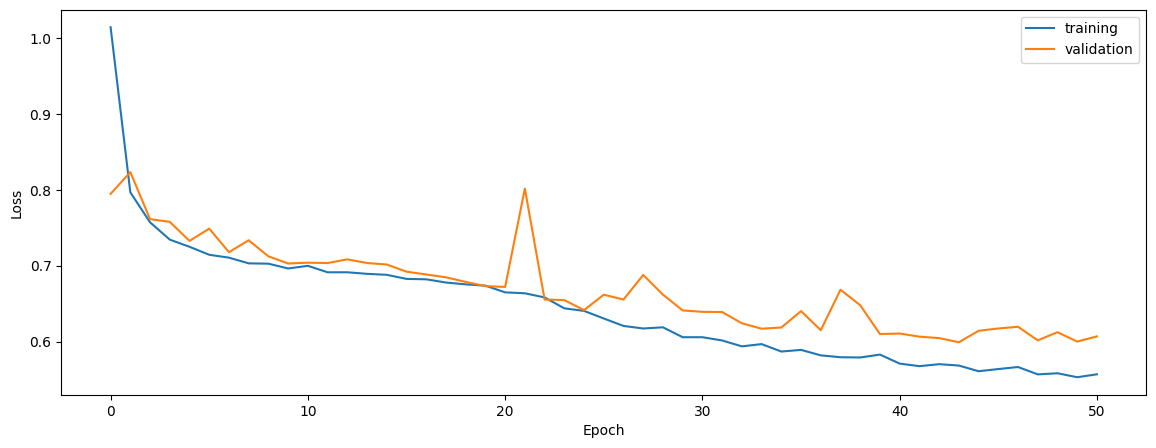

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuracy, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getAccuracy(train[1],train[4]))
print(getAccuracy(val[1],val[4]))
print(getAccuracy(test[1],test[4]))

train
0.7593135672761943
0.7462884254225561
0.7410691962644312


In [8]:
print(props['space'])
print(getAccuracy(train[1],train[4],train[3][0]))
print(getAccuracy(val[1],val[4],val[3][0]))
print(getAccuracy(test[1],test[4],test[3][0]))

native
0.7500919074772961
0.7427788306703907
0.7850354616129569


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getAccuracy(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getAccuracy(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getAccuracy(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.762441722014657
0.7581008423139433
0.7967089453919867


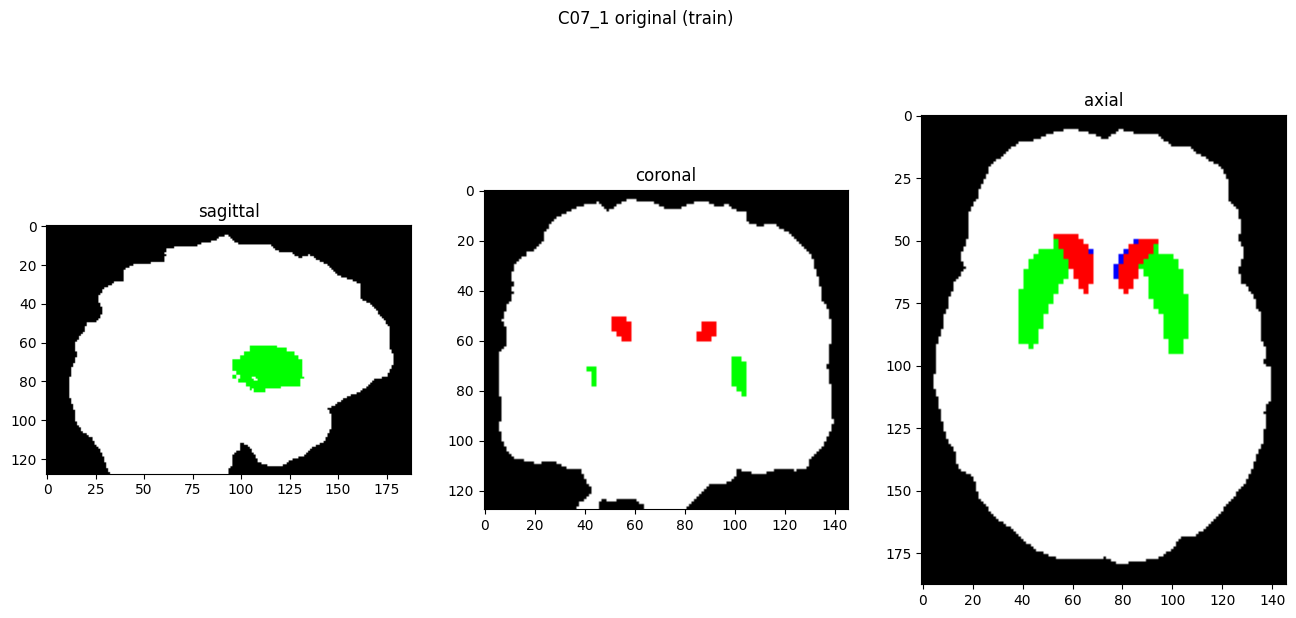

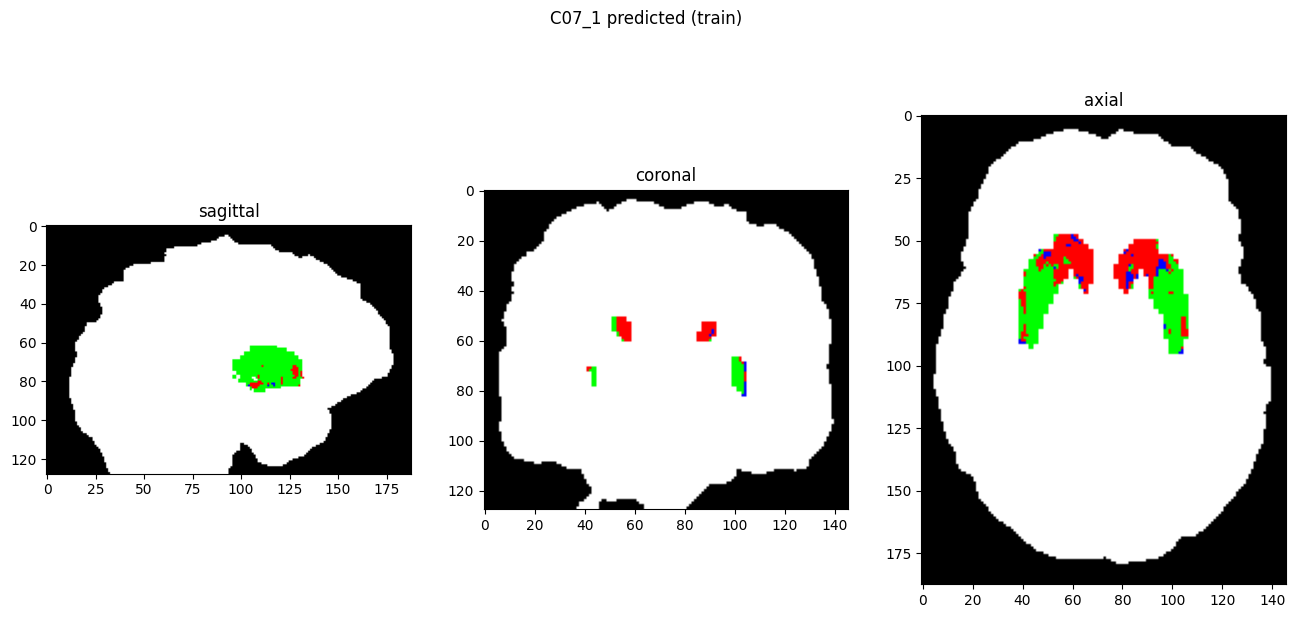

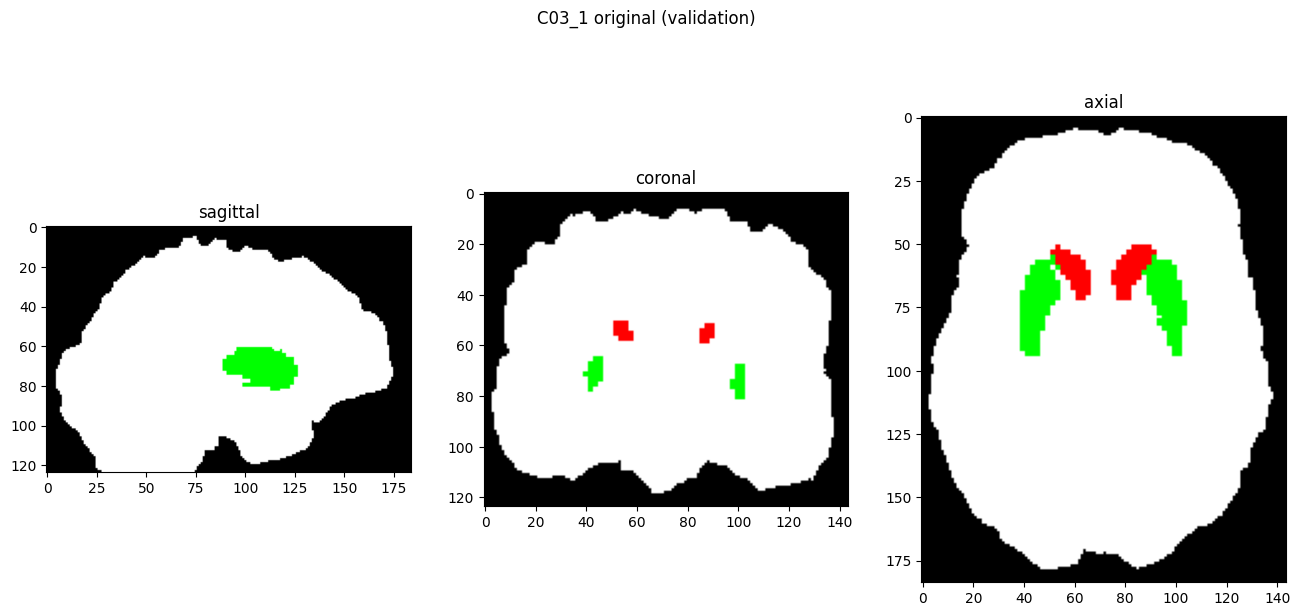

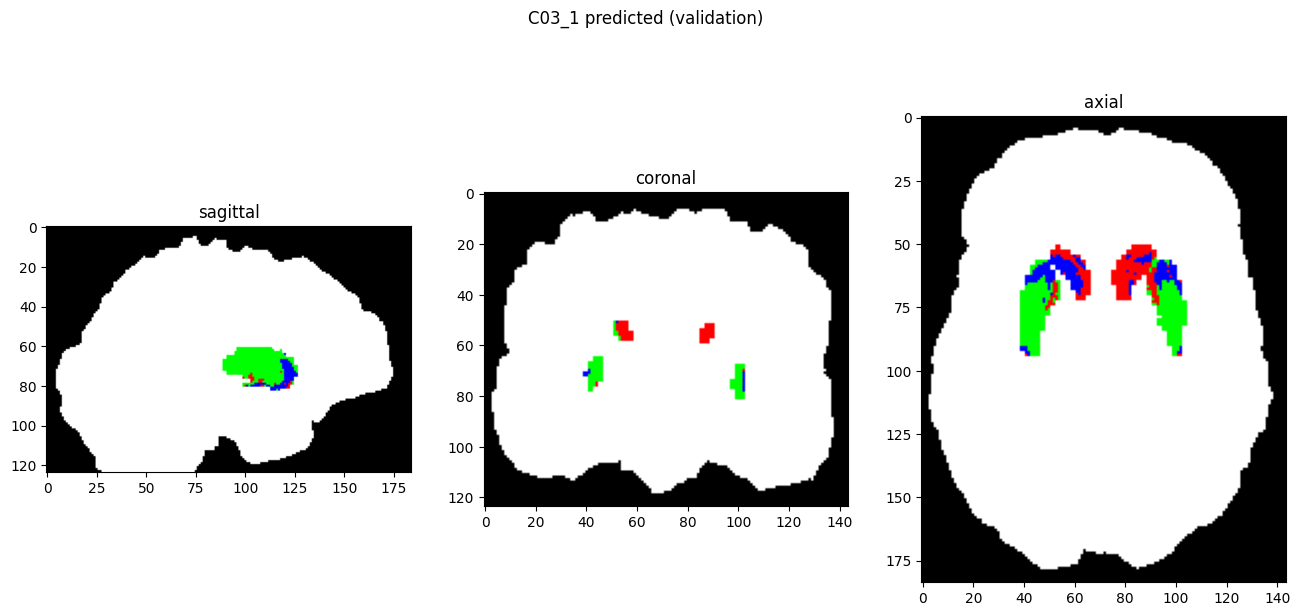

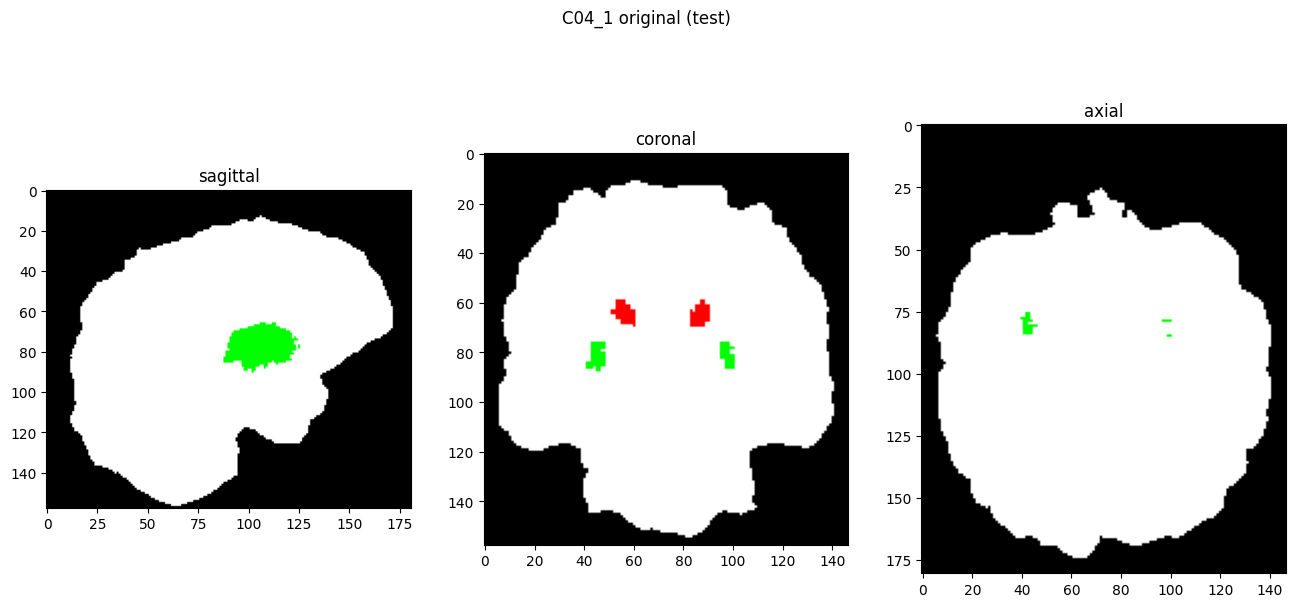

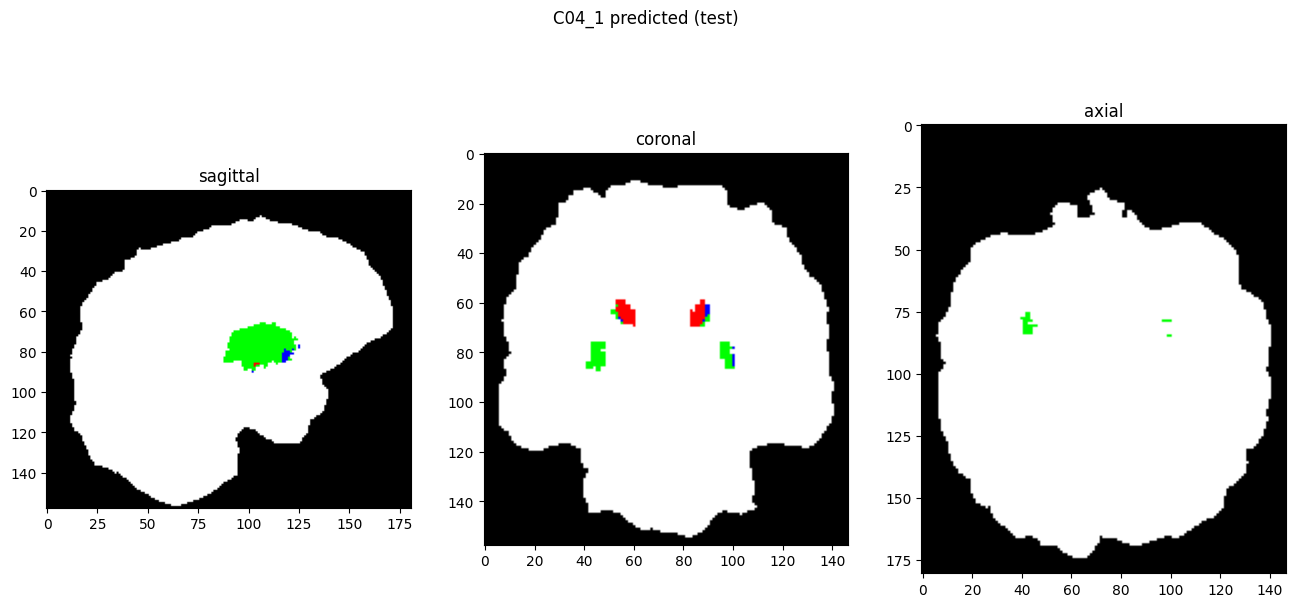

In [10]:
showResults(model, gen, threshold=0)